# Astana Real Estate Price Estimation Chatbot

## Introduction
Welcome to my Notebook for Real Estate Price Estimation in Astana!

In this notebook, I present a comprehensive approach to estimating real estate prices in Astana, Kazakhstan. Leveraging the power of Python and various libraries, I have developed a robust system that utilizes data from multiple sources to provide accurate price predictions.

Throughout the implementation, I incorporated the following key components:

* Data Acquisition from krisha.kz:
I gathered extensive real estate data from krisha.kz, one of the leading platforms for property listings in Kazakhstan. This data serves as the foundation for my price estimation model, encompassing a wide range of properties across Astana.

* Geocoding with 2GIS:
Utilizing geocoding services provided by 2GIS, I accurately pinpoint the geographical locations of properties within Astana. This crucial step enables me to incorporate spatial information into my analysis, enhancing the precision of my price estimations.

* Distance Calculation using Geopy:
By employing the Geopy library, I calculate distances between properties and various amenities, landmarks, and essential facilities in Astana. This feature adds value to my price estimations by considering proximity to key locations, which significantly influences property values.

* Information Retrieval from kn.kz:
Extracting pertinent details about residential complexes from kn.kz, I enrich my dataset with additional insights into neighborhood characteristics, amenities, and community features. This information contributes to a more comprehensive understanding of the factors affecting property prices in Astana.

By synergizing these tools and data sources, my notebook offers a sophisticated solution for estimating real estate prices in Astana. Through detailed code demonstrations and insightful analysis, I aim to provide valuable insights to stakeholders in the Astana housing market.

Let's dive into the code and explore the fascinating world of real estate price estimation in Astana!

### 1. Library Import
<font color='green'>In this section, we'll import the necessary libraries and will do seeding, versioning.</font>

In [1]:
import re
import ast
import time
import numpy as np
import pandas as pd
import datetime
import pickle
import csv
import warnings

from geopy.distance import geodesic

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import statsmodels.api as sm
import scipy.stats as stats

import requests
import json
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from data_mining import parse_data_from_krisha, preprocess_krisha_df, parse_data_from_kn,  preprocess_complex_df, find_missing_complexes
from data_mining import second_preprocess_complex_df, second_preprocess_krisha_df, geocode_2gis, process_and_clean_data
from data_mining import count_places_within_radius, checking_park, save_data, read_data, outliers_z_score, decision_normality, decision_hypothesis

# commiting RANDOM_SEED to make experiments repeatable!
RANDOM_SEED = 42

# commiting the package version to make the experiments repeatable:
!pip freeze > requirements.txt

sns.set_theme("notebook") 
sns.set_palette("Set2") 

### 2. Data Parsing
<font color='green'>In this section, we'll parse the data from its source.</font>

In [12]:
krisha_df_rought = parse_data_from_krisha(1, 1001)
save_data(krisha_df_rought, 'krisha_df_rought')

krisha_df_rought = read_data('krisha_df_rought')
print(f'The number of rows in krisha_df_rought: {krisha_df_rought.shape[0]}')
krisha_df_rought.head(3)

The number of rows in krisha_df_rought: 20074


name  \
0     3-комнатная квартира, 77 м², 1/4 этаж   
1    1-комнатная квартира, 40 м², 3/14 этаж   
2  1-комнатная квартира, 43.8 м², 6/18 этаж   

                                         information  \
0  2018 г.п., санузел раздельный, ✅Полноценная 3 ...   
1  жил. комплекс Jetisu.Lepsi, монолитный дом, 20...   
2  жил. комплекс BURABAY, монолитный дом, 2022 г....   

                                address         price    owner  
0               Есильский р-н, Е 496 10  33 000 000 〒  Риелтор  
1    Есильский р-н, Улы Дала — Ұлы дала  21 000 000 〒  Риелтор  
2  Алматы р-н, Ж. Нажимеденова 62 — А62  18 500 000 〒  Риелтор

In [16]:
complex_df_rought = parse_data_from_kn()
save_data(complex_df_rought, 'complex_df_rought')

complex_df_rought = read_data('complex_df_rought')
print(f'The number of rows in complex_df_rought: {complex_df_rought.shape[0]}')
complex_df_rought.head(3)

The number of rows in complex_df_rought: 1076


complex_name     city_district              address     year  \
0     ЖК Шыгыс  Астана, р-н Нура      ул. Сыганак, 14  2017 г.   
1    ЖК Mechta  Астана, р-н Нура     ул. Култегин, 11  2022 г.   
2  ЖК Sat City  Астана, р-н Нура  ул. Асфендиярова, 8  2021 г.   

                developer                                    characteristics  
0                     ASI  {'Класс ЖК': 'эконом', 'Умный дом': 'нет', 'Вы...  
1  Паркинг Системс Астана  {'Класс ЖК': 'комфорт', 'Умный дом': 'нет', 'В...  
2                  SAT-NS  {'Класс ЖК': 'комфорт', 'Умный дом': 'нет', 'В...

### 3. Raw Data Processing
<font color='green'>The preprocess consists of two stages 
* Extracting key data from collected information
* Unification of complex names in two tables for the next mergening</font>

In [14]:
krisha_df_rought = preprocess_krisha_df(krisha_df_rought)
display(krisha_df_rought.head(3))

name  \
0     3-комнатная квартира, 77 м², 1/4 этаж   
1    1-комнатная квартира, 40 м², 3/14 этаж   
2  1-комнатная квартира, 43.8 м², 6/18 этаж   

                                         information              address  \
0  2018 г.п., санузел раздельный, ✅Полноценная 3 ...             Е 496 10   
1  жил. комплекс Jetisu.Lepsi, монолитный дом, 20...             Улы Дала   
2  жил. комплекс BURABAY, монолитный дом, 2022 г....   Ж. Нажимеденова 62   

      price    owner  complex_name      house_type  in_pledge  \
0  33000000  Риелтор           NaN            None      False   
1  21000000  Риелтор  jetisu.lepsi  монолитный дом      False   
2  18500000  Риелтор       burabay  монолитный дом      False   

   construction_year  ceiling_height   furniture_info bathroom_info condition  \
0               2018             NaN              NaN    раздельный       NaN   
1               2023             3.0  частично мебели   совмещенный   хорошее   
2               2022             2.7              NaN   совмещенный       NaN   

   area  room_count floor floor_count       district  
0  77.0           3     1           4  Есильский р-н  
1  40.0           1     3          14  Есильский р-н  
2  43.8           1     6          18     Алматы р-н

In [17]:
complex_df_rought = preprocess_complex_df(complex_df_rought)
display(complex_df_rought.head(3))

complex_name     city_district              address     year  \
0        шыгыс  Астана, р-н Нура      ул. Сыганак, 14  2017 г.   
1       mechta  Астана, р-н Нура     ул. Култегин, 11  2022 г.   
2     sat city  Астана, р-н Нура  ул. Асфендиярова, 8  2021 г.   

                developer complex_class ceiling_height           house_type  \
0                     ASI        эконом          2.7 м  монолитно-каркасная   
1  Паркинг Системс Астана       комфорт            3 м            кирпичная   
2                  SAT-NS       комфорт            3 м  монолитно-каркасная   

  floor_count    parking                               elevator      heating  
0      7 – 16  надземный  пассажирский и грузовой, пассажирский  центральное  
1          10  надземный                           пассажирский  центральное  
2     12 – 18  надземный                пассажирский и грузовой          NaN

In [6]:
# Finding the missing complex names in complex_df or their names differed 
find_missing_complexes(krisha_df_rought, complex_df_rought)

Number of complexes from the complex_df that do not match with complexes in the krisha_df or absent: 179
List of these complexes: ['сатти 7', 'мжк астана', '7я', 'феникс', 'vip городок саранда', 'толенды', 'алтын булак', 'абылайхан', 'бронкс', 'орынбор', 'отан 2', 'арлан', 'времена года. весна', 'sezim qala.senim', 'озен', 'абылайхан 2', 'сказка по ул. сейфулина', 'сарайшик', 'happy land', 'greenline.terra', 'апарт отель yes astana', 'жилой дом по ул. айнакол', 'сан сити', 'акбулак nak', 'кулан 2', 'kinghouse', 'сармат 2', 'capital park.flowers', 'алтын шар 1', 'ala tau comfort', 'лея за рекой', 'sezim qala.baqyt', 'кок жайлау', 'баскару 1', 'arman deluxe', 'гулдер', 'sclub', 'есиль (бокейхана', 'нипи 2', 'greenline.asyl mura', 'биик шанырак', '3 гектара', 'орбита 2', 'бигвилль поколение', 'greenline.aqua', 'меркурий 2', 'городской романс', 'greenline.asyl mura jubanov', 'арман тау', 'бахыт премиум', 'zhana omir', 'сармат 1', 'family village (кг)', 'ельтай', 'магистральный 2', 'елорда

In [18]:
# Correction of names of residential complexes in two tables so that later they can be combined as key words
# So addition of non-exhaustive housing complexes and correction some of data in complex_df
complex_df = second_preprocess_complex_df(complex_df_rought)
krisha_df = second_preprocess_krisha_df(krisha_df_rought)

# Cheking 
find_missing_complexes(krisha_df, complex_df)

Number of complexes from the complex_df that do not match with complexes in the krisha_df or absent: 1
List of these complexes: [nan]


#### 3.1 Parsing, preprocessing and additing new data

In [34]:
def parsing_addition_data(first_page, last_page):
    """
    Parse data from the first page to the last page, preprocess it, and add it to the original DataFrame.

    Args:
    first_page (int): The first page number to start parsing from.
    last_page (int): The last page number to parse up to.
    krisha_df (pandas.DataFrame): The original DataFrame to which the parsed and preprocessed data will be added.

    Returns:
    pandas.DataFrame: The updated DataFrame with parsed and preprocessed data added.
    """
    
    # Function for parsing data from the first page to the last page
    addition_krisha_df_rought = parse_data_from_krisha(first_page, last_page)
    
    # Preprocess the data
    addition_krisha_df_rought = preprocess_krisha_df(addition_krisha_df_rought)
    
    # Additional data preprocessing
    addition_krisha_df = second_preprocess_krisha_df(addition_krisha_df_rought)
    
    return addition_krisha_df

# Apply the function to the DataFrame
addition_krisha_df = parsing_addition_data(1, 400)
save_data(addition_krisha_df, 'addition_krisha_df')

addition_krisha_df = read_data('addition_krisha_df')
print(f'The number of rows in addition_krisha_df: {addition_krisha_df.shape[0]}')
display(addition_krisha_df.head(3))

#  Adding additionally downloaded table to main table
krisha_df = pd.concat([krisha_df, addition_krisha_df], ignore_index=True)

The number of rows in addition_krisha_df: 5120


name  \
0   1-комнатная квартира, 36.64 м², 8/9 этаж   
1  2-комнатная квартира, 50.75 м², 7/12 этаж   
2    3-комнатная квартира, 125 м², 3/43 этаж   

                                         information  \
0  жил. комплекс Megapolis, 2024 г.п., состояние:...   
1  жил. комплекс Женева, кирпичный дом, 2023 г.п....   
2  жил. комплекс Северное сияние, монолитный дом,...   

                       address     price    owner     complex_name  \
0      Нажмиденова — Жумабаева  16999999  Риелтор        megapolis   
1   Шамши Калдаякова 44 — А-52  18000000  Риелтор           женева   
2                     Достык 5  51000000  Риелтор  северное сияние   

       house_type  in_pledge  construction_year  ceiling_height  \
0             NaN      False               2024             2.7   
1   кирпичный дом      False               2023             3.0   
2  монолитный дом      False               2008             2.8   

  furniture_info bathroom_info         condition    area  room_count  floor  \
0            NaN   совмещенный  черновая отделка   36.64           1    8.0   
1            NaN           NaN  черновая отделка   50.75           2    7.0   
2            NaN             2           хорошее  125.00           3    3.0   

   floor_count    district  
0          9.0  Алматы р-н  
1         12.0  Алматы р-н  
2         43.0         NaN

### 4. Handling Missing Values and Feature Engineering
<font color='green'>Here, we'll handle missing values, and create new features.</font>

### 4.1 Geo-coding of addresses of residential complexes by using 2GIS in complex_df and creating new features based on coordinates. 

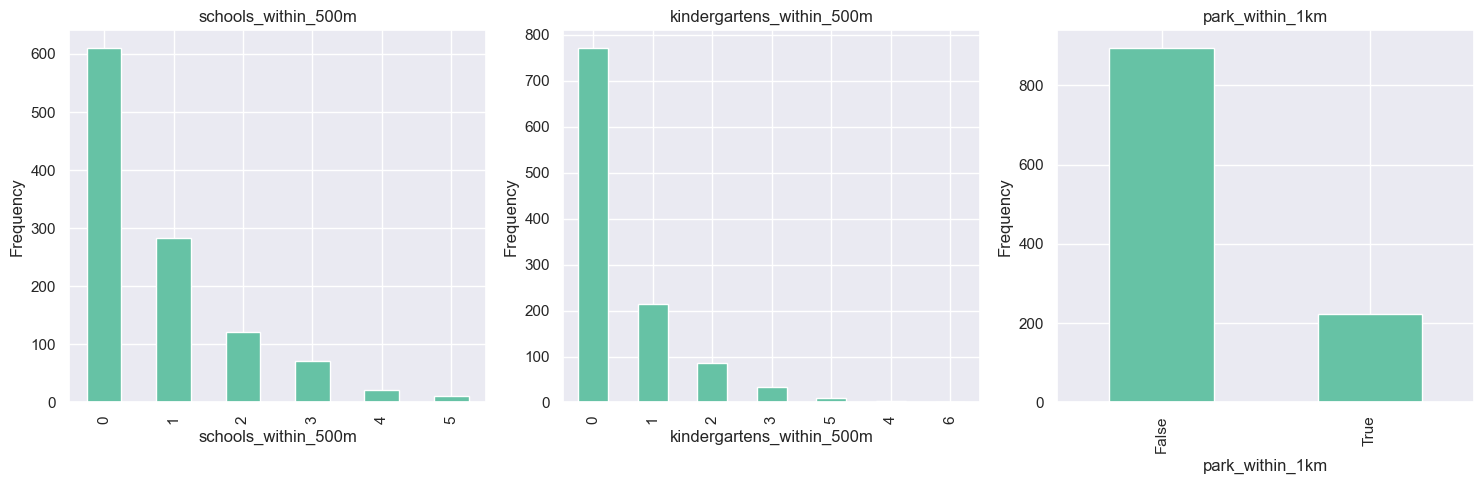

In [45]:
def geo_process_complex_df(complex_df):
    """
    Process complex dataframe by geocoding, parsing coordinates,and counting nearby places.
    For this purpose, dictionaries with names of schools, kindergartens, parks of Astana with coordinates are used.
    Args:
        complex_df (DataFrame): DataFrame containing complex information.

    Returns:
        DataFrame: DataFrame with created new 4 features.
    """
    # Geocoding and parsing coordinates
    complex_df['coordinates_2gis'] = complex_df['address'].apply(geocode_2gis)
    complex_df['coordinates_2gis'] = complex_df['coordinates_2gis'].apply(lambda x: ast.literal_eval(x))
    complex_df['schools_within_1km'] = complex_df['coordinates_2gis'].apply(lambda x: count_places_within_radius('school', x, 1000))
    complex_df['kindergartens_within_1km'] = complex_df['coordinates_2gis'].apply(lambda x: count_places_within_radius('kindergarten', x, 1000))
    complex_df['park_within_2km'] = complex_df['coordinates_2gis'].apply(lambda x: checking_park(x, 2000))
    
    return complex_df

# Apply the function to the DataFrame
complex_df = geo_process_complex_df(complex_df)
save_data(complex_df, 'complex_df')

# Visualization of newly created cat features with the help of coordinates
complex_df = read_data('complex_df')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
categorical_features = ['schools_within_500m', 'kindergartens_within_500m', 'park_within_1km']

for i, ax in enumerate(axes):
    category_counts = complex_df[categorical_features[i]].value_counts()
    category_counts.plot(kind='bar', ax=ax)
    ax.set_title(categorical_features[i])
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()


### 4.2 Geo-coding of the addresses of those apartments at which the name of the residential complex is not known and search for the name of residential complexes through coordinates

In [35]:
def geo_process_krisha_df(krisha_df):
    
    # Geocoding addresses of rows that doesn't have 'complex_name' by using geocode_2gis function
    indexes = krisha_df[krisha_df.complex_name.isna()].index
    krisha_df.loc[indexes, 'coordinates_2gis'] = krisha_df.loc[indexes, 'address'].apply(geocode_2gis)

    # Convert 'coordinates_2gis' to dictionary format
    krisha_df['coordinates_2gis'] = krisha_df['coordinates_2gis'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else None)
    
    return krisha_df

def filling_complex_names_in_krisha_df(krisha_df):
    
    # Get the indexes where 'complex_name' is NaN
    indexes = krisha_df[krisha_df.complex_name.isna()].index
    
    # First stage of filling in missing values in the 'complex_name' feature
    # Using a dictionary created from coordinates and names of residential complexes, we find identical coordinates in the krisha_df table
    complex_df = pd.read_csv('data/complex_df.csv')
    dict_found_pair = complex_df[['coordinates_2gis', 'complex_name']].set_index('coordinates_2gis')['complex_name'].to_dict()
    
    # Fill NaN 'complex_name' with values from 'coordinates_2gis' dictionary if their coordinates match
    krisha_df.loc[indexes, 'complex_name'] = krisha_df.loc[indexes, 'coordinates_2gis'].map(dict_found_pair)


    # Second stage of filling in missing values in the 'complex_name' feature
    # Using the function, we find residential complexes within a radius of 400 meters, 
    # and if the type of building and the year of construction match
    def matching_house_search_in_radius(row, df_complex):
        if pd.isnull(row['complex_name']):
            coordinates = row['coordinates_2gis']
            house_type = row['house_type']
            construction_year = row['construction_year']
            floor_count = row['floor_count']
            
            if coordinates is None:
                return None
            else:
                nearest_complex = None
                min_distance = float('inf')  # Initializing the minimum distance with infinity
                
                for idx, row_complex in df_complex.iterrows():
                    distance = geodesic(coordinates, row_complex['coordinates_2gis']).meters
                    complex_year = row_complex.get('year')  # Getting the construction year of the complex
                    complex_house_type = row_complex.get('house_type')  # Getting the building type of the complex
                    min_complex_floor = row_complex.get('min_floor_count')  # Minimum floor of the complex
                    max_complex_floor = row_complex.get('max_floor_count') + 1  # Maximum floor of the complex + 1
                    
                    if (pd.isnull(floor_count) or min_complex_floor <= floor_count <= max_complex_floor) and \
                            (pd.isnull(house_type) or complex_house_type == house_type) and \
                            abs(complex_year - construction_year) <= 3 and \
                            distance <= 400 : # radius 400 metrs
                        if distance < min_distance:
                            min_distance = distance
                            nearest_complex = row_complex['complex_name']
                            
                return nearest_complex
        else:
            return row['complex_name'] 
    
    
    # Applying the function to fill missing values in the 'complex_name' column
    krisha_df['complex_name'] = krisha_df.apply(lambda row: matching_house_search_in_radius(row, complex_df), axis=1)

    return krisha_df

# Applying the first function 
krisha_df  = geo_process_krisha_df(krisha_df)

# Applying the seconf function 
krisha_df = filling_complex_names_in_krisha_df(krisha_df)

# Saving data
save_data(krisha_df, 'krisha_df')

display(krisha_df.head(3))

name  \
0     3-комнатная квартира, 77 м², 1/4 этаж   
1    1-комнатная квартира, 40 м², 3/14 этаж   
2  1-комнатная квартира, 43.8 м², 6/18 этаж   

                                         information  \
0  2018 г.п., санузел раздельный, ✅Полноценная 3 ...   
1  жил. комплекс Jetisu.Lepsi, монолитный дом, 20...   
2  жил. комплекс BURABAY, монолитный дом, 2022 г....   

                     address     price    owner  complex_name      house_type  \
0                   Е 496 10  33000000  Риелтор         kemel             NaN   
1        Улы Дала — Ұлы дала  21000000  Риелтор  jetisu.lepsi  монолитный дом   
2   Ж. Нажимеденова 62 — А62  18500000  Риелтор       burabay  монолитный дом   

   in_pledge  construction_year  ceiling_height   furniture_info  \
0      False               2018             NaN              NaN   
1      False               2023             3.0  частично мебели   
2      False               2022             2.7              NaN   

  bathroom_info condition  area  room_count  floor  floor_count  \
0    раздельный       NaN  77.0           3    1.0          4.0   
1   совмещенный   хорошее  40.0           1    3.0         14.0   
2   совмещенный       NaN  43.8           1    6.0         18.0   

        district        coordinates_2gis  
0  Есильский р-н  (51.073887, 71.427446)  
1  Есильский р-н                     NaN  
2     Алматы р-н                     NaN

### 4.3 Mergering two tables by the name of the residential complex 

In [2]:
def merge_dataframes(krisha_df):
    """
    Merge two DataFrames based on the 'complex_name' column.

    Args:
    krisha_df_path (str): Path to the CSV file containing the Krisha DataFrame.
    complex_df_path (str): Path to the CSV file containing the Complex DataFrame.

    Returns:
    pandas.DataFrame: Merged DataFrame containing data from both DataFrames.
    """
    complex_df = pd.read_csv('data/complex_df.csv')
    
    merged_df = pd.merge(left=krisha_df, right=complex_df, on='complex_name', how='left', suffixes=('', '_complex'))
    display(merged_df.info())
    
    return merged_df

# Reading the table for reproducibility
krisha_df = read_data('krisha_df')

# Applying the function 
merged_df = merge_dataframes(krisha_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20668 entries, 0 to 20667
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       20668 non-null  object 
 1   information                20668 non-null  object 
 2   address                    20645 non-null  object 
 3   price                      20668 non-null  int64  
 4   owner                      20668 non-null  object 
 5   complex_name               17719 non-null  object 
 6   house_type                 17951 non-null  object 
 7   in_pledge                  20668 non-null  bool   
 8   construction_year          20668 non-null  int64  
 9   ceiling_height             17797 non-null  float64
 10  furniture_info             1356 non-null   object 
 11  bathroom_info              13865 non-null  object 
 12  condition                  12782 non-null  object 
 13  area                       20668 non-null  flo

None

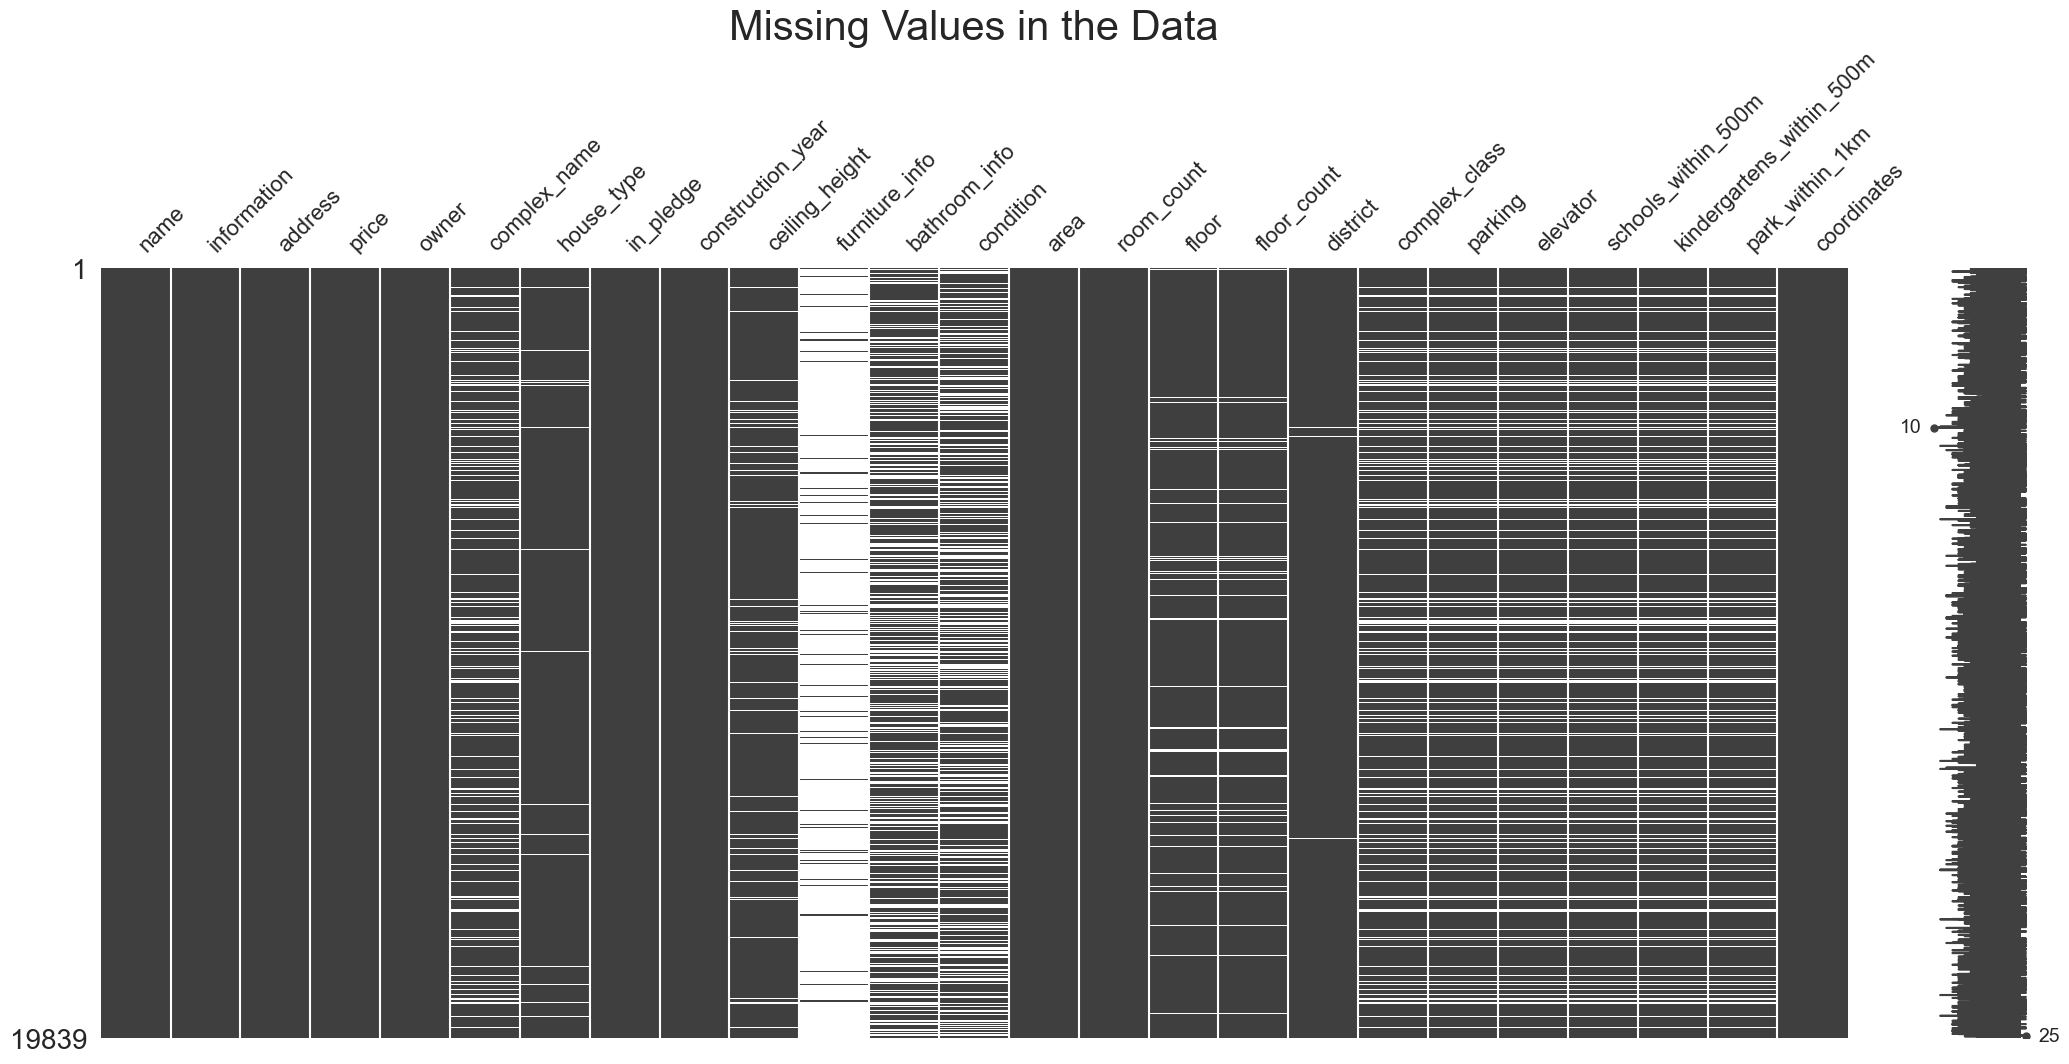

In [3]:
# Combining the same features to fill in passages in them, removing unnecessary columns from the second table, etc
merged_df = process_and_clean_data(merged_df)

# Visualize missing values in the DataFrame
msno.matrix(merged_df)
plt.title('Missing Values in the Data', fontsize=30)
plt.show()

### 4.4 Filling in the geo-features using the same functions as the complex_df, and creating new features regarding distance.

In [2]:
def geo_preprocess_merged_df(merged_df):
    
    # Convert string representations of coordinates to coordinate lists
    merged_df['coordinates'] = merged_df['coordinates'].astype(str)
    merged_df['coordinates'] = merged_df['coordinates'].apply(lambda x: ast.literal_eval(x))
    
    # Filling missing values
    
    
    # Fill missing values for nearby parks within 1 kilometer
    null_index = merged_df[merged_df['park_within_1km'].isna()].index
    merged_df.loc[null_index, 'park_within_1km'] = merged_df.loc[null_index, 'coordinates'].apply(lambda x: checking_park(x, 2000))
    
    # Fill missing values for nearby schools within 500m
    null_index = merged_df[merged_df['schools_within_500m'].isna()].index
    merged_df.loc[null_index, 'schools_within_500m'] = merged_df.loc[null_index, 'coordinates'].apply(lambda x: count_places_within_radius('school', x, 1000))

    # Fill missing values for nearby kindergartens within 500m
    null_index = merged_df[merged_df['kindergartens_within_500m'].isna()].index
    merged_df.loc[null_index, 'kindergartens_within_500m'] = merged_df.loc[null_index, 'coordinates'].apply(lambda x: count_places_within_radius('kindergarten', x, 1000))
    
    # Creating new features 

    # Taking 'Baiterek Monument' as the geographical center
    geo_center_of_astana = (51.128318, 71.430381)
    merged_df['distance_to_center'] = merged_df['coordinates'].apply(lambda x: geodesic(geo_center_of_astana, x).kilometers)

    # Distances to Botanical Garden
    botanical_garden = (51.106433, 71.416329)
    merged_df['distance_to_botanical_garden'] = merged_df['coordinates'].apply(lambda x: geodesic(botanical_garden, x).kilometers)

    # Distances to Triathlon Park
    triathlon_park = (51.13593, 71.449809)
    merged_df['distance_to_triathlon_park'] = merged_df['coordinates'].apply(lambda x: geodesic(triathlon_park, x).kilometers)

    # Distances to Astana Park
    astana_park = (51.156264, 71.419961)
    merged_df['distance_to_astana_park'] = merged_df['coordinates'].apply(lambda x: geodesic(astana_park, x).kilometers)

    # Distances to Treatment Facility
    treatment_facility = (51.144302, 71.337247)
    merged_df['distance_to_treatment_facility'] = merged_df['coordinates'].apply(lambda x: geodesic(treatment_facility, x).kilometers)

    # Distances to First Railway Station
    railway_station_1 = (51.195572, 71.409173)
    merged_df['distance_to_railway_station_1'] = merged_df['coordinates'].apply(lambda x: geodesic(railway_station_1, x).kilometers)

    # Distances to Second Railway Station
    railway_station_2 = (51.112488, 71.531596)
    merged_df['distance_to_railway_station_2'] = merged_df['coordinates'].apply(lambda x: geodesic(railway_station_2, x).kilometers)

    # Distances to Industrial Zone
    industrial_zone = (51.140231, 71.551219)
    merged_df['distance_to_industrial_zone'] = merged_df['coordinates'].apply(lambda x: geodesic(industrial_zone, x).kilometers)


    return merged_df

# Applying the function 
merged_df = geo_preprocess_merged_df(merged_df)

### 4.5  Last stage of feature engineering

In [5]:
def create_additional_features(df):
    """
    Processed DataFrame with additional engineered features such as 
    'kzt_sq_m', 'last_floor', and 'first_floor'.
    """
    # Compute price per square meter in Kazakhstani Tenge (KZT)
    # We will need it for predicting missing values in features using a random forest,
    # as well as for data analysis. In the end, we will remove it.
    df['kzt_sq_m'] = df['price'] / df['area']

    # Identify if the apartment is on the last floor
    df['last_floor'] = df['floor'] == df['floor_count']

    # Identify if the apartment is on the first floor 
    # Presumably, if the apartment is on the second floor and the residential complex has a underground, 
    # then from the courtyard it is also considered the first floor.
    df['first_floor'] = (df['floor'] == 1) | ((df['floor'] == 2) & (df['parking'] == 'underground'))

    return df

# Applying the function 
merged_df = create_additional_features(merged_df)

### 4.6 Manually filling missing values, as well as using Random Forest Classifier for imputation

In [6]:
def manual_data_imputation(df):
    """
    Imputes missing data in the DataFrame manually based on specified conditions.
    Changes were made for houses built before 2000
    At the end, lines containing missings in the following features were deleted
    ['house_type', 'ceiling_height', 'floor_count', 'district', 'floor', 'floor_count']
    
    Args:
        df (DataFrame): The DataFrame containing the data to be imputed.

    Returns:
        DataFrame: The DataFrame with some missing data imputed and cleaned.
    """
    
    # Checking for missing complex names
    missing_complex_name = df.complex_name.isna()

    # Imputing data based on specific conditions
    condition = (df.construction_year <= 2000) & (missing_complex_name)
    df.loc[condition, 'complex_class'] = 'economy'
    df.loc[condition, 'parking'] = 'no'
    df.loc[condition & (df.floor_count <= 6), 'elevator'] = 'no'
    df.loc[condition & (df.floor_count > 6), 'elevator'] = 'yes'

    condition = (df.construction_year < 1964) & (df.floor_count < 5) & missing_complex_name 
    df.loc[condition, 'complex_name'] = 'cталинка'

    condition = (df.construction_year < 1964) & (df.floor_count < 5) & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 3.0

    condition = (df.construction_year < 1964) & (df.floor_count < 5) & (df.house_type.isna())
    df.loc[condition, 'house_type'] = 'brick'

    condition = (df.construction_year < 1970) & (df.floor_count == 5) & missing_complex_name
    df.loc[condition, 'complex_name'] = 'хрущёвка'

    condition = (df.construction_year < 1970) & (df.bathroom_info == 'combined') & missing_complex_name
    df.loc[condition, 'complex_name'] = 'хрущёвка'

    condition = (df.construction_year < 1970) & (df.floor_count == 5) & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 2.5

    condition = df.construction_year.between(1964, 1982) & missing_complex_name
    df.loc[condition, 'complex_name'] = 'бережневка'

    condition = (df.construction_year > 1983) & (df.house_type == 'panel') & missing_complex_name
    df.loc[condition, 'complex_name'] = 'панелька нового типа'

    condition = (df.construction_year > 1983) & (df.house_type == 'panel') & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 2.7

    condition = (df.construction_year < 2000) & (df.house_type.isna())
    df.loc[condition, 'house_type'] = 'panel'

    condition = (df.construction_year < 2000) & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 2.7

    df.loc[(df['complex_name'].isna()), 'complex_name'] = 'no name'

    # Dropping rows with missing values in certain columns
    columns_to_check = ['house_type', 'ceiling_height', 'floor_count', 'district', 'floor', 'floor_count']
    df = df.dropna(subset=columns_to_check)
    
    # Since there are a lot of missing values in the 'furniture_info' feature, we will remove it.
    df = df.drop(['furniture_info'], axis=1)
    
    return df


def fill_missing_by_rfc(merged_df, random_seed=42):
    """
    Fill missing values in the ['elevator', 'parking', 'complex_class'] using RandomForestClassifier.

    Parameters:
        merged_df (DataFrame): Input DataFrame with missing values.
        random_seed (int): Random seed for reproducibility. Default is 42.

    Returns:
        DataFrame: DataFrame with missing values filled.
    """

    df_filled = merged_df[['floor_count', 'room_count', 'area', 'ceiling_height', 'construction_year',
                           'elevator', 'parking', 'complex_class', 'house_type', 'district', 'kzt_sq_m']].copy()

    df_filled.fillna('missing', inplace=True)

    features = ['floor_count', 'room_count', 'area', 'ceiling_height', 'construction_year', 'house_type', 'district', 'kzt_sq_m']

    label_encoders = {}
    for column in df_filled.columns:
        if df_filled[column].dtype == 'object':
            label_encoders[column] = LabelEncoder()
            df_filled[column] = label_encoders[column].fit_transform(df_filled[column].astype(str))

    missing_rows = df_filled['elevator'].isin([label_encoders['elevator'].transform(['missing'])[0]]) | \
                   df_filled['parking'].isin([label_encoders['parking'].transform(['missing'])[0]]) | \
                   df_filled['complex_class'].isin([label_encoders['complex_class'].transform(['missing'])[0]])

    df_missing = df_filled[missing_rows]
    df_not_missing = df_filled[~missing_rows]

    X_train_elevator, _, y_train_elevator, _ = train_test_split(df_not_missing[features], df_not_missing['elevator'], test_size=0.1, random_state=random_seed)
    model_elevator = RandomForestClassifier(random_state=random_seed)
    model_elevator.fit(X_train_elevator, y_train_elevator)

    predicted_values_elevator = model_elevator.predict(df_missing[features])
    df_filled.loc[df_missing.index, 'elevator'] = predicted_values_elevator

    X_train_parking, _, y_train_parking, _ = train_test_split(df_not_missing[features], df_not_missing['parking'], test_size=0.2, random_state=random_seed)
    model_parking = RandomForestClassifier(random_state=random_seed)
    model_parking.fit(X_train_parking, y_train_parking)

    predicted_values_parking = model_parking.predict(df_missing[features])
    df_filled.loc[df_missing.index, 'parking'] = predicted_values_parking

    X_train_complex, _, y_train_complex, _ = train_test_split(df_not_missing[features], df_not_missing['complex_class'], test_size=0.2, random_state=random_seed)
    model_complex = RandomForestClassifier(random_state=random_seed)
    model_complex.fit(X_train_complex, y_train_complex)

    predicted_values_complex = model_complex.predict(df_missing[features])
    df_filled.loc[df_missing.index, 'complex_class'] = predicted_values_complex

    for column in label_encoders:
        df_filled[column] = label_encoders[column].inverse_transform(df_filled[column])

    merged_df['elevator'] = df_filled['elevator']
    merged_df['parking'] = df_filled['parking']
    merged_df['complex_class'] = df_filled['complex_class']

    return merged_df


shape_before_cleaning = merged_df.shape[0]

# Applying the first function 
merged_df = manual_data_imputation(merged_df)

# Applying the second function 
merged_df = fill_missing_by_rfc(merged_df)

shape_after_cleaning = merged_df.shape[0]
print("Number of deleted rows: ", shape_before_cleaning - shape_after_cleaning)

Number of deleted rows:  1405


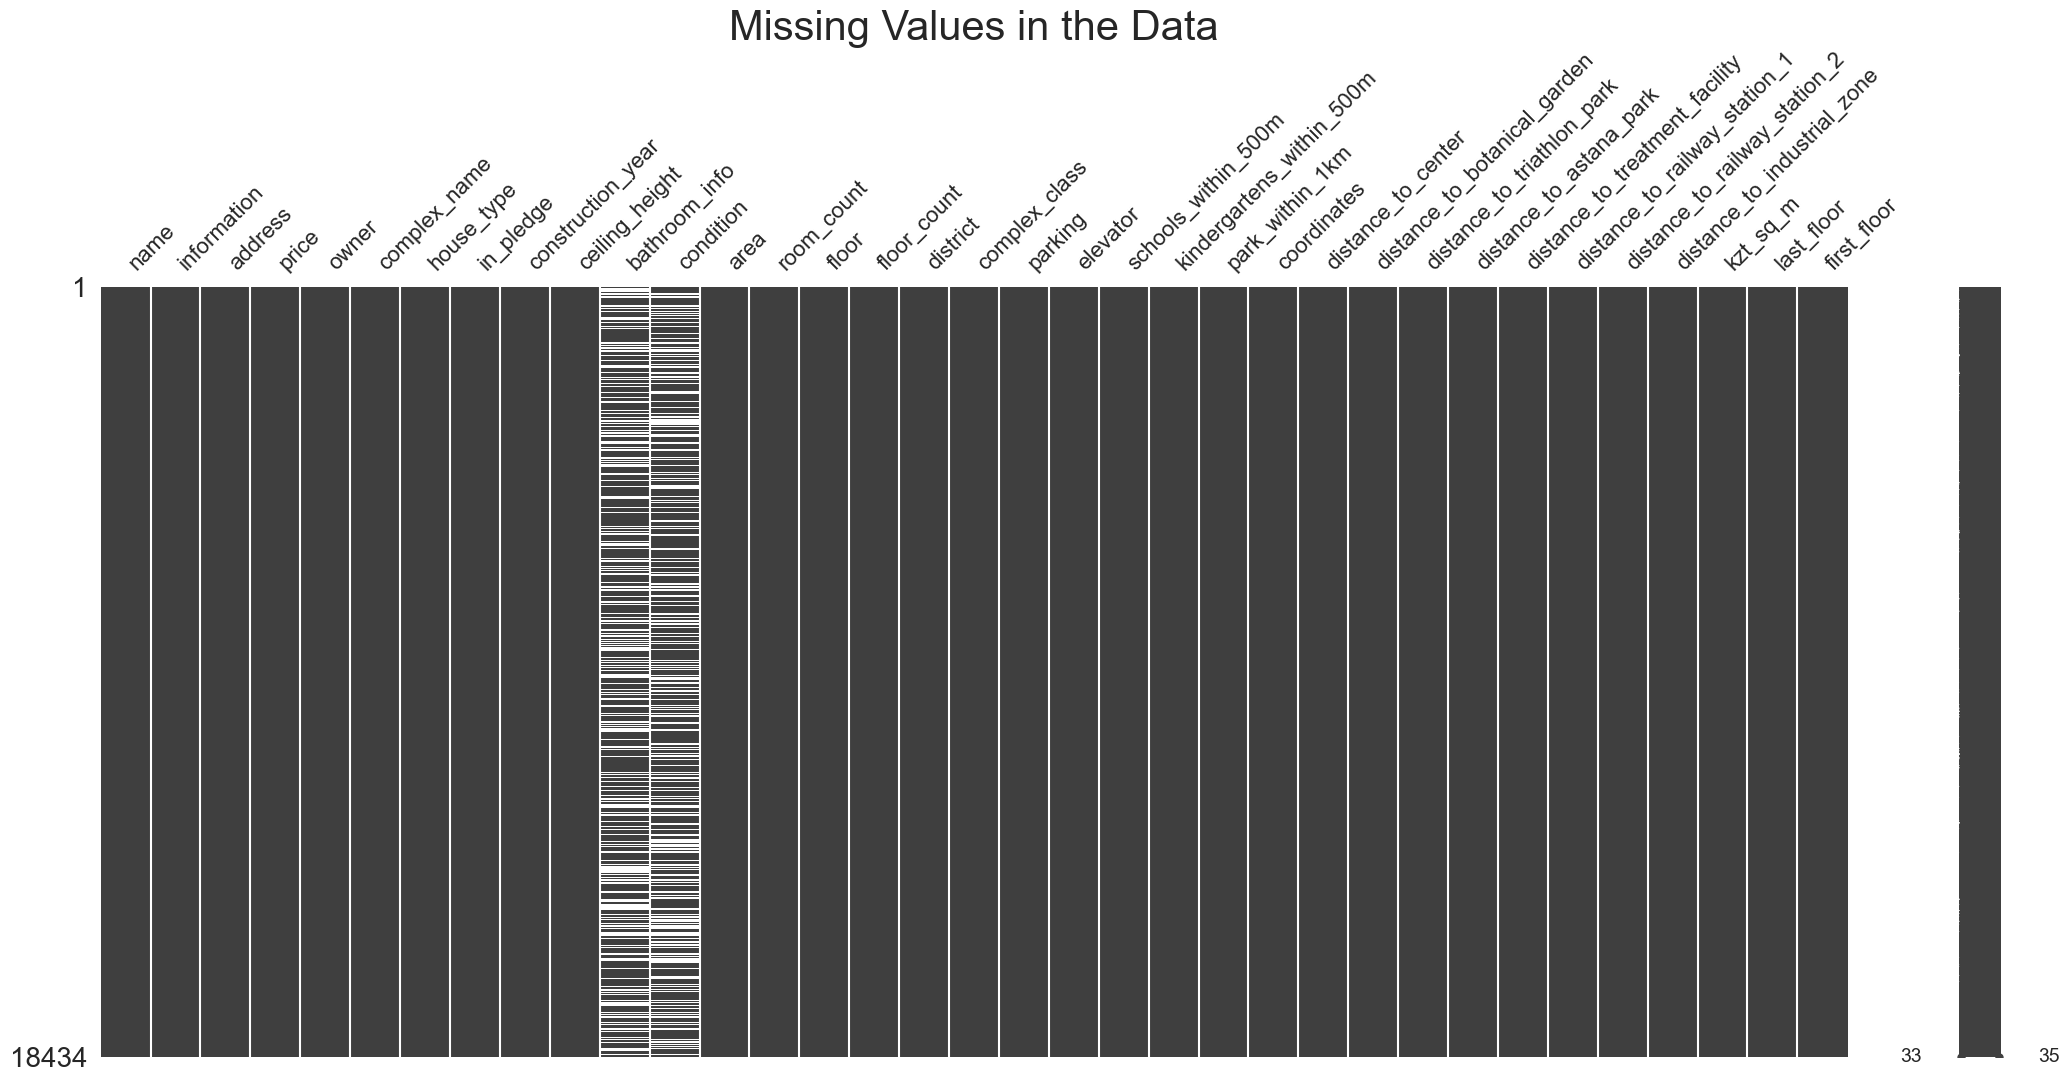

In [7]:
save_data(merged_df, "merged_df")

# Visualize missing values in the DataFrame
msno.matrix(merged_df)
plt.title('Missing Values in the Data', fontsize=30)
plt.show()

I decided to retain 'bathroom_info' and 'condition' and fill missing values with a special indicator -999 during encoding

### 5. Data Analysis
<font color='green'>Let's look at the data that we have to analyse.

<table > 

   <tr>
    <th>Column</th>
    <th>Description</th>
    <th>Type</th>
  </tr>
  
   <tr>
    <td>price</td>
    <td>the total cost of the apartment</td>
    <td>int64</td>
  </tr>

   <tr>
    <td>owner</td>
    <td>ad from a realtor or from the property owner</td>
    <td>object</td>
  </tr>

   <tr>
    <td>complex_name</td>
    <td>name of residential complexes</td>
    <td>object</td>
  </tr>

   <tr>
    <td>house_type</td>
    <td>describes the materials used in the construction of the house</td>
    <td>object</td>
  </tr> 
    
  <tr>
    <td>in_pledge</td>
    <td>a boolean feature indicating whether the apartment is pledged or not</td>
    <td>bool</td>
  </tr>
    
  <tr>
    <td>construction_year</td>
    <td>the year of construction of the house</td>
    <td>int64</td>
  </tr>
    
   <tr>
    <td>ceiling_height</td>
    <td>the ceiling height in the apartment</td>
    <td>float64</td>
  </tr>

   <tr>
    <td>bathroom_info</td>
    <td>number of bathrooms in the apartment</td>
    <td>object</td>
  </tr>
    
   <tr>
    <td>condition</td>
    <td>the type of finishing in the apartment</td>
    <td>object</td>
  </tr> 
   
   <tr>
    <td>area</td>
    <td>the area of the apartment</td>
    <td>float64</td>
  </tr>  
    
   <tr>
    <td>room_count</td>
    <td>the number of rooms in the apartment</td>
    <td>int64</td>
  </tr>  
    
   <tr>
    <td>floor</td>
    <td>the floor on which the apartment is located</td>
    <td>int64</td>
  </tr> 
    
   <tr>
    <td>floor_count</td>
    <td>the number of floors in the building</td>
    <td>int64</td>
  </tr> 
    
  <tr>
    <td>district</td>
    <td>the name of the district where the building is located</td>
    <td>object</td>
  </tr> 

   <tr>
    <td>complex_class</td>
    <td>the housing class</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>parking</td>
    <td>information about the presence and type of parking</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>elevator</td>
    <td>information about the presence of an elevator in the building</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>schools_within_500m</td>
    <td>the number of schools within a radius of 500 meters</td>
    <td>float64</td>
  </tr> 
    
   <tr>
    <td>kindergartens_within_500m</td>
    <td>the number of kindergartens within a radius of 500 meters</td>
    <td>ifloat64</td>
  </tr> 
    
   <tr>
    <td>park_within_1km</td>
    <td>the presence of a park within a kilometer radius</td>
    <td>bool</td>
  </tr> 
    
   <tr>
    <td>coordinates</td>
    <td>the coordinates of the residential building (latitude, longitude)</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>distance_to_center</td>
    <td>the distance to the city center in kilometers</td>
    <td>float64</td>
  </tr> 
    
   <tr>
    <td>distance_to_botanical_garden</td>
    <td>the distance to the botanical park in kilometers</td>
    <td>float64</td>
  </tr> 
 
   <tr>
    <td>distance_to_triathlon_park</td>
    <td>the distance to the triathlonl park in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_astana_park</td>
    <td>the distance to the central astana park in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_treatment_facility</td>
    <td>the distance to the waste treatment facility in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_railway_station_1</td>
    <td>the distance to the first railway station on the right bank in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_railway_station_2</td>
    <td>the distance to the second railway station on the left bank in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_industrial_zone</td>
    <td>the distance to the industrial zone in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>kzt_sq_m</td>
    <td>the price per square meter in Kazakh Tenge (KZT)</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>last_floor</td>
    <td>a boolean feature indicating whether the floor is the last one or not</td>
    <td>bool</td>
  </tr>
  <tr>
    <td>first_floor</td>
    <td>a boolean feature indicating whether the floor is the first one or not</td>
    <td>bool</td>
  </tr>

</table>

</font>

In [2]:
df_for_analysing = read_data("merged_df")
# At the beginning, I decided to remove the anomalous single 'apartment' that costs almost 2 billion tenge.
indices_to_drop = df_for_analysing[(df_for_analysing['price'] >= 1000000000)].index
df_for_analysing.drop(indices_to_drop, inplace=True)
display(df_for_analysing.describe())
object_columns = df_for_analysing.select_dtypes(include=['object'])
display(object_columns.describe())

price  construction_year  ceiling_height          area  \
count  1.843300e+04       18433.000000    18433.000000  18433.000000   
mean   3.743519e+07        2014.570716        2.845681     68.817866   
std    3.835651e+07          11.506476        0.178873     41.709771   
min    4.000000e+06        1898.000000        2.000000     11.000000   
25%    2.000000e+07        2012.000000        2.700000     42.000000   
50%    2.700000e+07        2018.000000        2.800000     59.000000   
75%    4.050000e+07        2022.000000        3.000000     82.000000   
max    7.500000e+08        2026.000000        4.800000    773.300000   

         room_count         floor   floor_count  schools_within_500m  \
count  18433.000000  18433.000000  18433.000000         18433.000000   
mean       2.150654      6.671133     11.481419             1.219281   
std        1.081595      4.388128      5.175144             2.112217   
min        1.000000      1.000000      1.000000             0.000000   
25%        1.000000      3.000000      9.000000             0.000000   
50%        2.000000      6.000000     10.000000             0.000000   
75%        3.000000      9.000000     14.000000             2.000000   
max       43.000000     41.000000     43.000000            15.000000   

       kindergartens_within_500m  distance_to_center  \
count               18433.000000        18433.000000   
mean                    0.868117            5.559624   
std                     1.861327           45.954191   
min                     0.000000            0.250284   
25%                     0.000000            2.872140   
50%                     0.000000            3.956213   
75%                     1.000000            5.208025   
max                    15.000000         2565.387251   

       distance_to_botanical_garden  distance_to_triathlon_park  \
count                  18433.000000                18433.000000   
mean                       6.215413                    5.757489   
std                       45.946980                   45.965086   
min                        0.519604                    0.357386   
25%                        2.431434                    3.106359   
50%                        4.816675                    4.297644   
75%                        6.759455                    5.356048   
max                     2565.184867                 2566.428367   

       distance_to_astana_park  distance_to_treatment_facility  \
count             18433.000000                    18433.000000   
mean                  6.328699                        8.985068   
std                  45.947873                       45.850843   
min                   0.328701                        0.766380   
25%                   3.393801                        5.301223   
50%                   4.692346                        7.482007   
75%                   6.368021                        9.841432   
max                2563.755468                     2558.635747   

       distance_to_railway_station_1  distance_to_railway_station_2  \
count                   18433.000000                   18433.000000   
mean                        9.459230                       9.278104   
std                        45.909278                      45.996259   
min                         0.000000                       0.000000   
25%                         6.358577                       5.513721   
50%                         8.077983                       8.037209   
75%                        10.306243                      10.290037   
max                      2561.724357                    2572.674709   

       distance_to_industrial_zone      kzt_sq_m  
count                 18433.000000  1.843300e+04  
mean                     10.344167  5.116387e+05  
std                      45.984665  1.644444e+05  
min                       0.382038  1.050420e+05  
25%                       6.290774  4.076923e+05  
50%                       9.405560  4.782609e+05  
75%            

name  \
count                                   18433   
unique                                  12088   
top     1-комнатная квартира, 38 м², 2/9 этаж   
freq                                       23   

                                              information        address  \
count                                               18433          18433   
unique                                              17795          10289   
top     жил. комплекс Кутты Мекен, монолитный дом, 202...   Калдаяков 26   
freq                                                    7             62   

        owner complex_name  house_type bathroom_info condition district  \
count   18433        18433       18433         12368     12364    18433   
unique      2         1002           3             3         3        6   
top     owner      no name  monolithic      combined      good   almaty   
freq     9454         1201       11747          6863      9216     5567   

       complex_class      parking elevator             coordinates  
count          18433        18433    18433                   18433  
unique             4            3        2                    2546  
top          comfort  underground      yes  (51.130001, 71.375612)  
freq            8230         8886    16604                     190

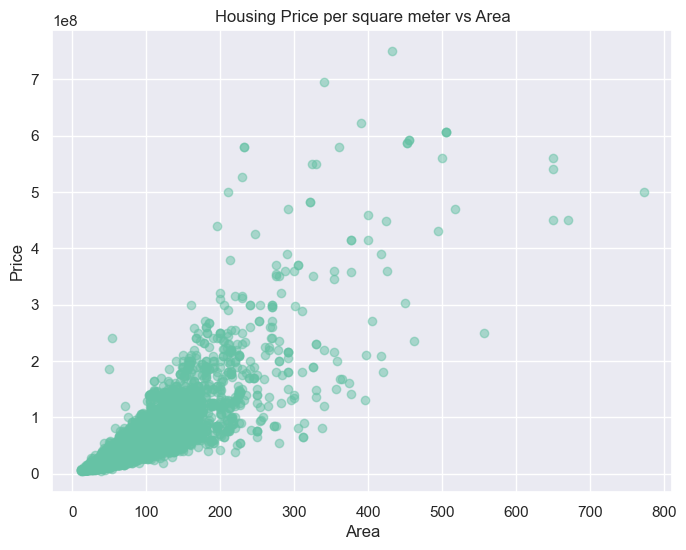

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(df_for_analysing['area'], df_for_analysing['price'], alpha=0.5)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Housing Price per square meter vs Area')

plt.grid(True)
plt.show()

In [3]:
# Filter out apartments with an area of less than 28 for old _houses, as these are not apartments but rather rooms
indices_to_drop = df_for_analysing[(df_for_analysing['area'] < 28) & (df_for_analysing.construction_year <= 2000)].index
df_for_analysing.drop(indices_to_drop, inplace=True)

# Filter out apartments with an area of less than 15 for all hoses, as these are not apartments but rather rooms
indices_to_drop = df_for_analysing[(df_for_analysing['area'] < 15)].index
df_for_analysing.drop(indices_to_drop, inplace=True)

#  In the dataset, there are some strange apartments with a price less than 200,000 tenge. It's better to remove them, except for the old houses
indices_to_drop = df_for_analysing[(df_for_analysing['kzt_sq_m'] <= 200000)&(df_for_analysing['construction_year'] >= 2000)].index
df_for_analysing.drop(indices_to_drop, inplace=True)

***Decided to split into two datasets and train two models, will need to load additional data for the second dataset***

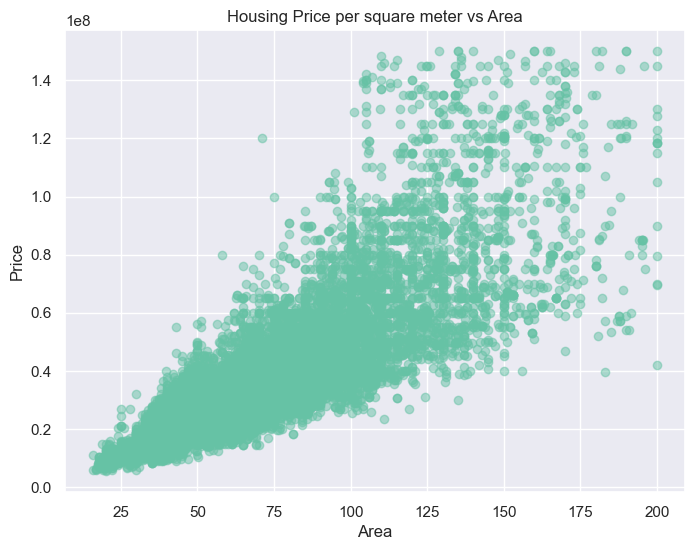

In [4]:
df = df_for_analysing[(df_for_analysing['area']<=200) & (df_for_analysing['price']<=150000000)]
df_elite = df_for_analysing[~((df_for_analysing['area']<=200) & (df_for_analysing['price']<=150000000))]

plt.figure(figsize=(8, 6))
plt.scatter(df['area'], df['price'], alpha=0.5)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Housing Price per square meter vs Area')

plt.grid(True)
plt.show()

### 5.1 Numerical features

Text(0.5, 1.0, 'Distribution of Prices for all apartments')

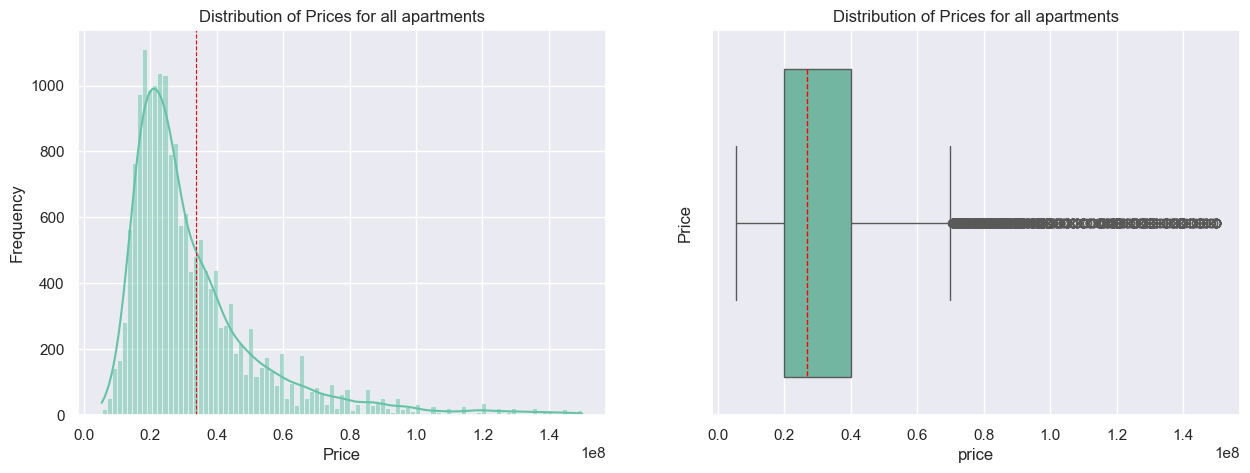

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['price'], kde=True, ax=axes[0])
axes[0].set(xlabel='Price', ylabel='Frequency')
axes[0].set_title('Distribution of Prices for all apartments')
axes[0].axvline(df['price'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['price'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Price')
axes[1].set_title('Distribution of Prices for all apartments')

In [5]:
# Perform the D'Agostino and Pearson's omnibus normality test
_, p = stats.normaltest(df['price'])

decision_normality(p, alpha = 0.05 )

p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.


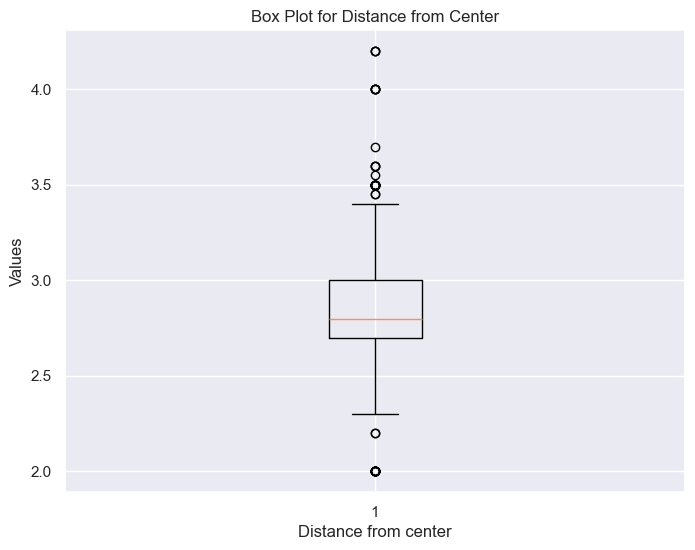

In [51]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['ceiling_height'])
plt.xlabel('Distance from center')
plt.ylabel('Values')
plt.title('Box Plot for Distance from Center')
plt.grid(True)
plt.show()

In [6]:
def process_ceiling_height(x):
    if not pd.isnull(x):
        return min([2.5, 2.7, 2.8, 2.9, 3, 3.3, 3.5, 4], key=lambda y: abs(x - y))
    else:
        return np.nan

df['ceiling_height'] = df['ceiling_height'].apply(process_ceiling_height)

/var/folders/5m/lmk4nz253xxbzljz0whcbdj80000gn/T/ipykernel_766/1968990343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ceiling_height'] = df['ceiling_height'].apply(process_ceiling_height)


***I decided to round the ceiling height because there is very little data for some of them, and 2 seems to be an incorrect user input***

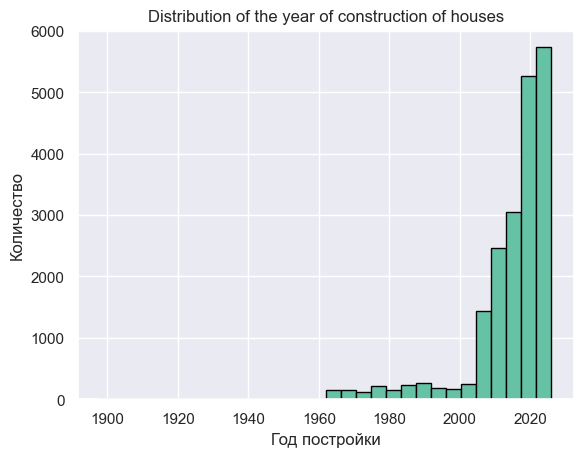

In [55]:
plt.hist(merged_df['construction_year'], bins=30, edgecolor='black')
plt.title('Distribution of the year of construction of houses')
plt.xlabel('Год постройки')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

In [7]:
df = df[df['construction_year'] > 1950]

***We are filtering 1950s rhinestones at home, there are a couple of apartments there.***

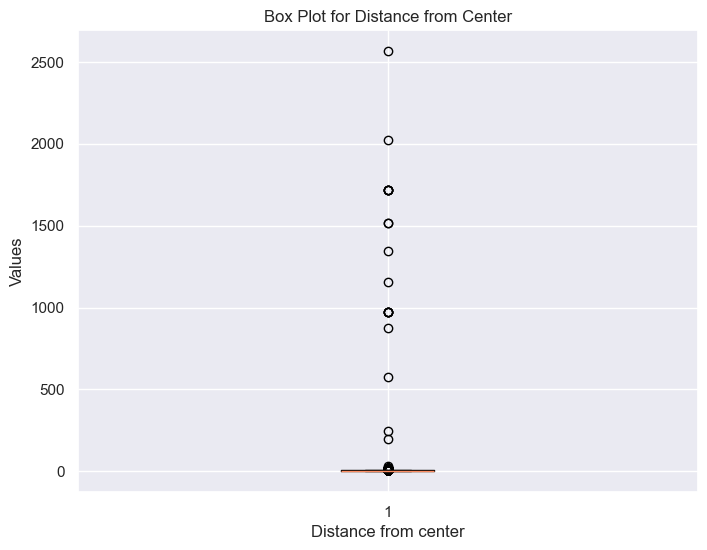

In [37]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['distance_to_center'])
plt.xlabel('Distance from center')
plt.ylabel('Values')
plt.title('Box Plot for Distance from Center')
plt.grid(True)
plt.show()

In [8]:
# Removing data outside Astana
is_not_astana = df[(df['distance_to_center'] > 14)].shape[0]
df = df[(df['distance_to_center'] < 14)].reset_index(drop=True)
print("Number of apartments outside Astana, filtering them:", is_not_astana)

Number of apartments outside Astana, filtering them: 80


***The addresses that are outside of Astana are removed at this stage, most often because people with errors entered their addresses, but there are few of them***

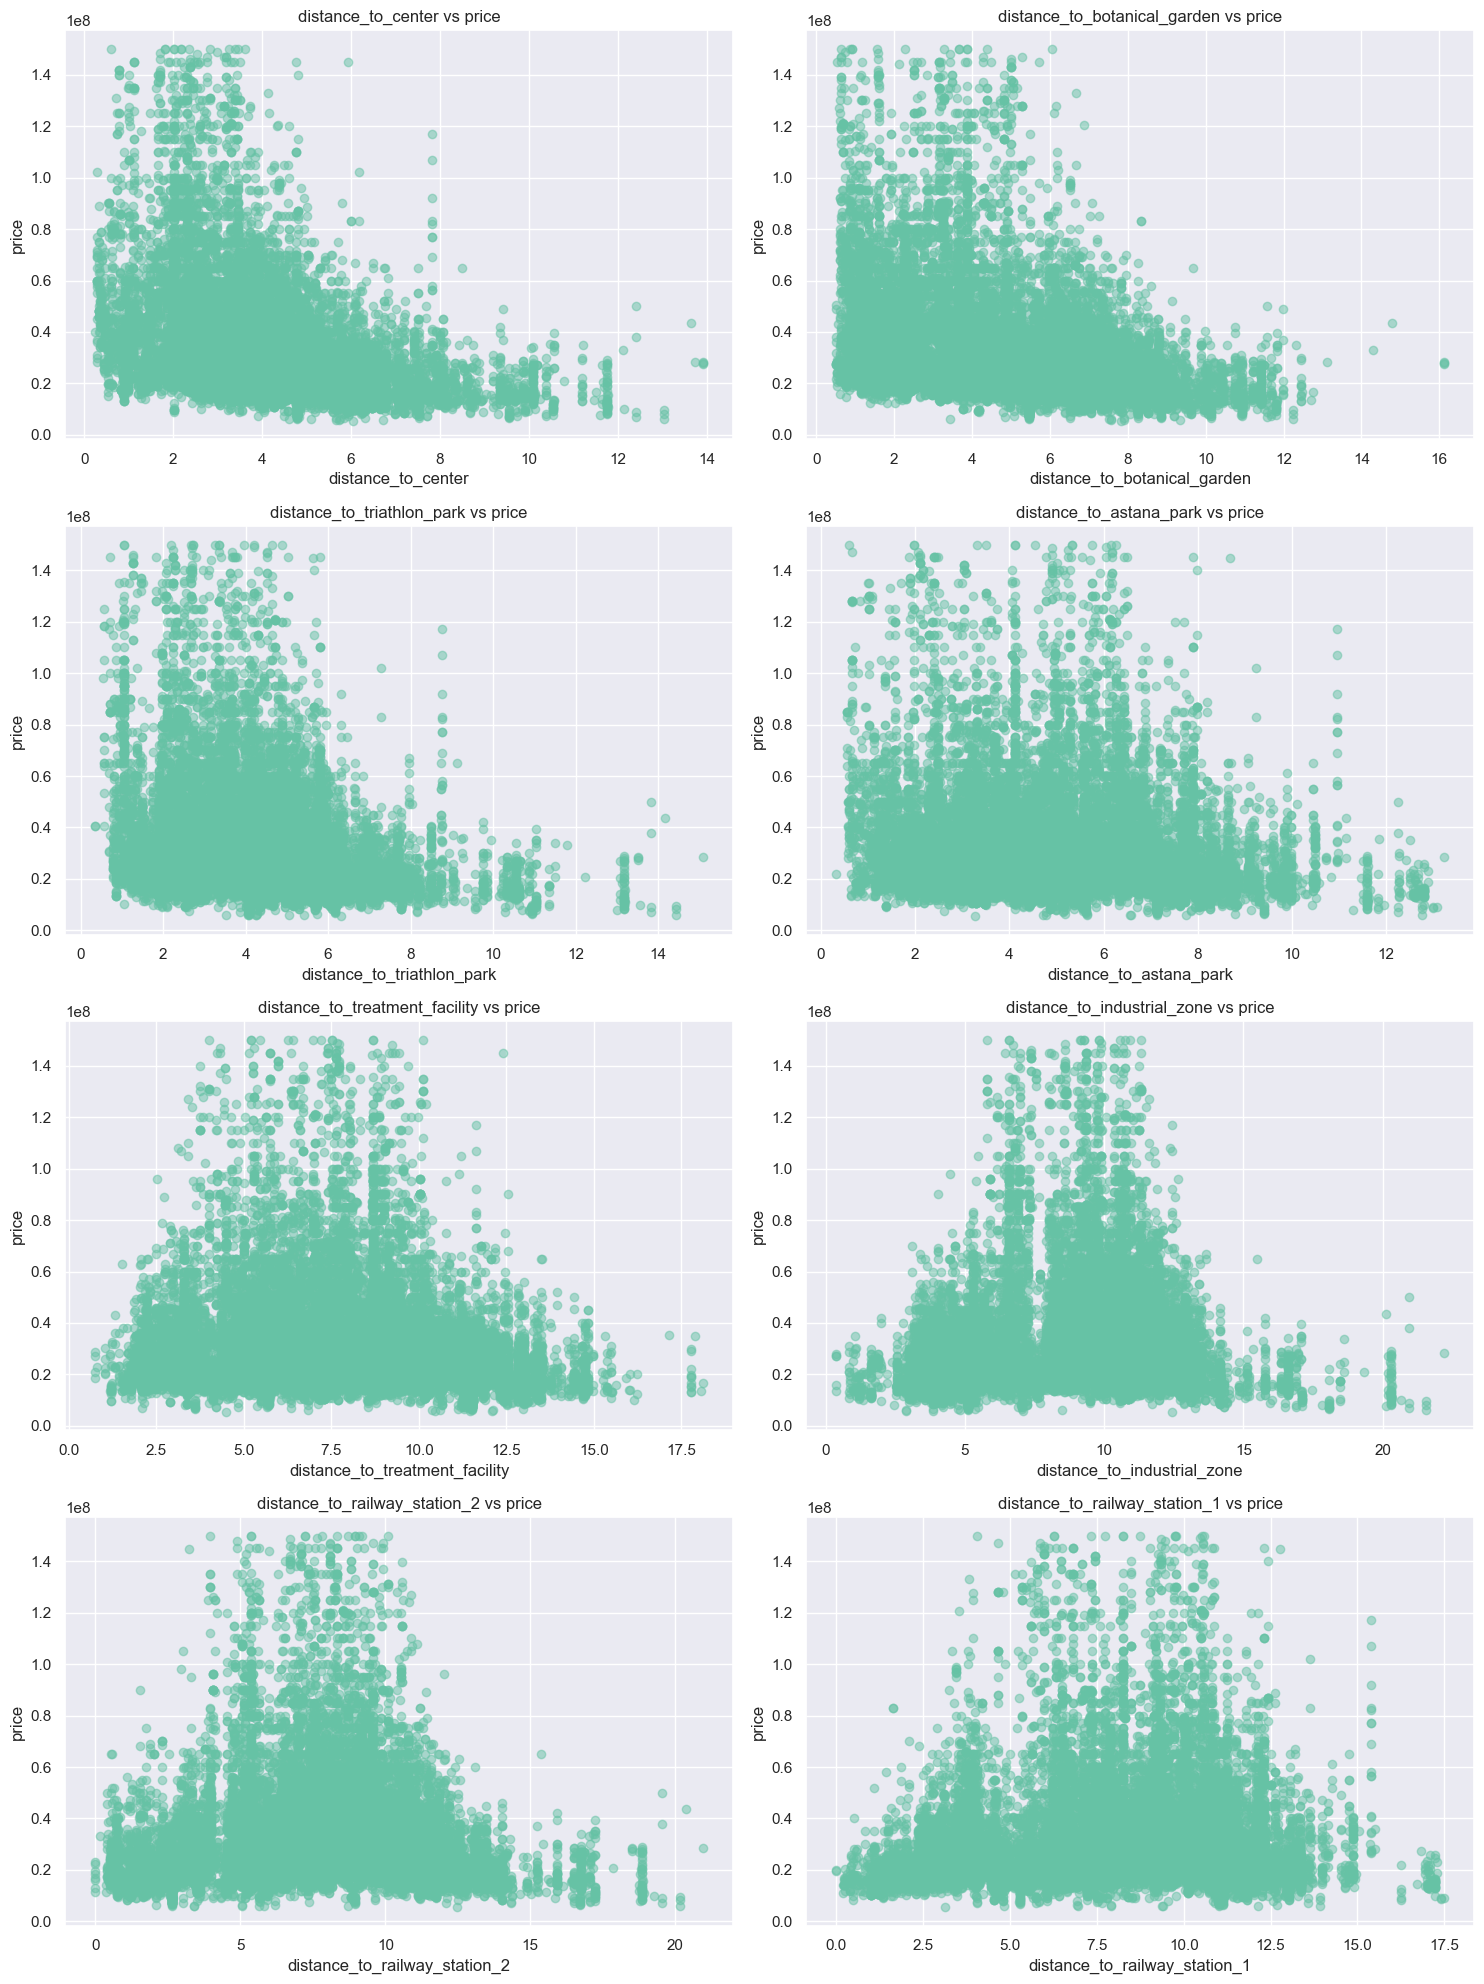

In [69]:
features =[
    'distance_to_center' , 'distance_to_botanical_garden', 
    'distance_to_triathlon_park', 'distance_to_astana_park', 
    'distance_to_treatment_facility', 'distance_to_industrial_zone',
    'distance_to_railway_station_2', 'distance_to_railway_station_1',
]

target_feature = 'price'

num_rows = (len(features) + 1) // 2 
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.scatter(df[feature], df[target_feature], alpha=0.5)
    ax.set_title(f'{feature} vs {target_feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel(target_feature)
    
plt.tight_layout()

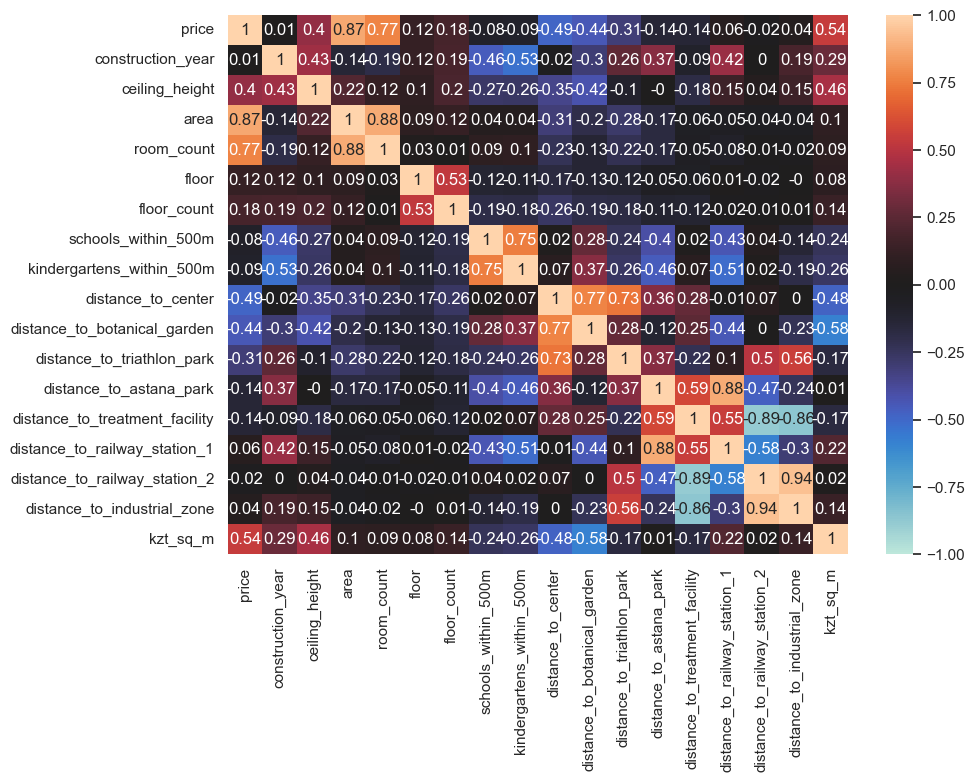

In [70]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

corr = numeric_columns.corr(method='spearman').round(decimals=2)

plt.rcParams['figure.figsize'] = (10, 7)
heatmap_corr = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0)
plt.show()

***There is a high correlation between distances, so we will likely have to remove about half of them. However, despite the strong correlation between area and the target variable, we will retain it.***

### 5.3 Categorical features

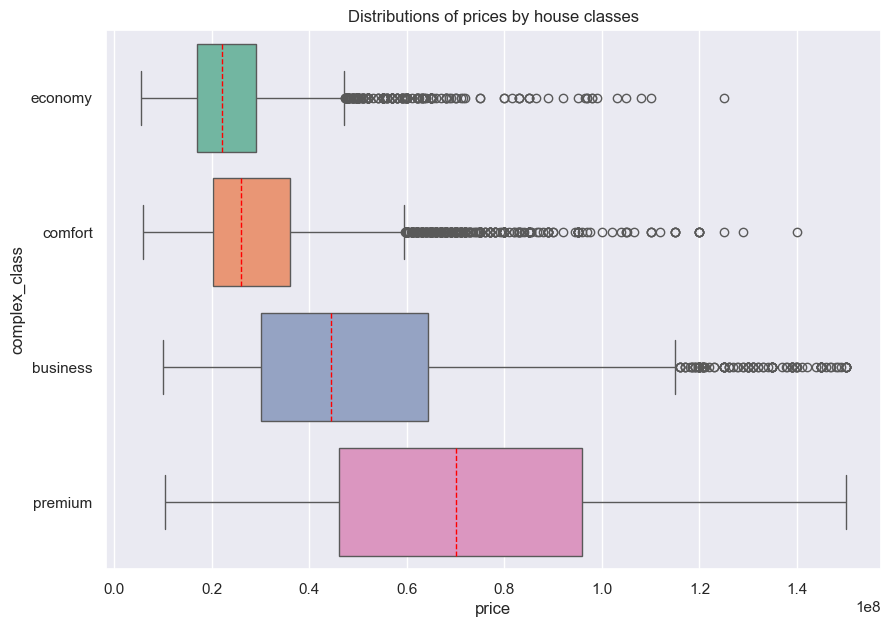

In [75]:
ax = sns.boxplot(df, x='price', y='complex_class', orient='h', hue='complex_class', medianprops={"color": "red", "linestyle": '--'})
plt.title('Distributions of prices by house classes')
plt.show()

***As expected, the price increases depending on the class. We will keep this feature.***

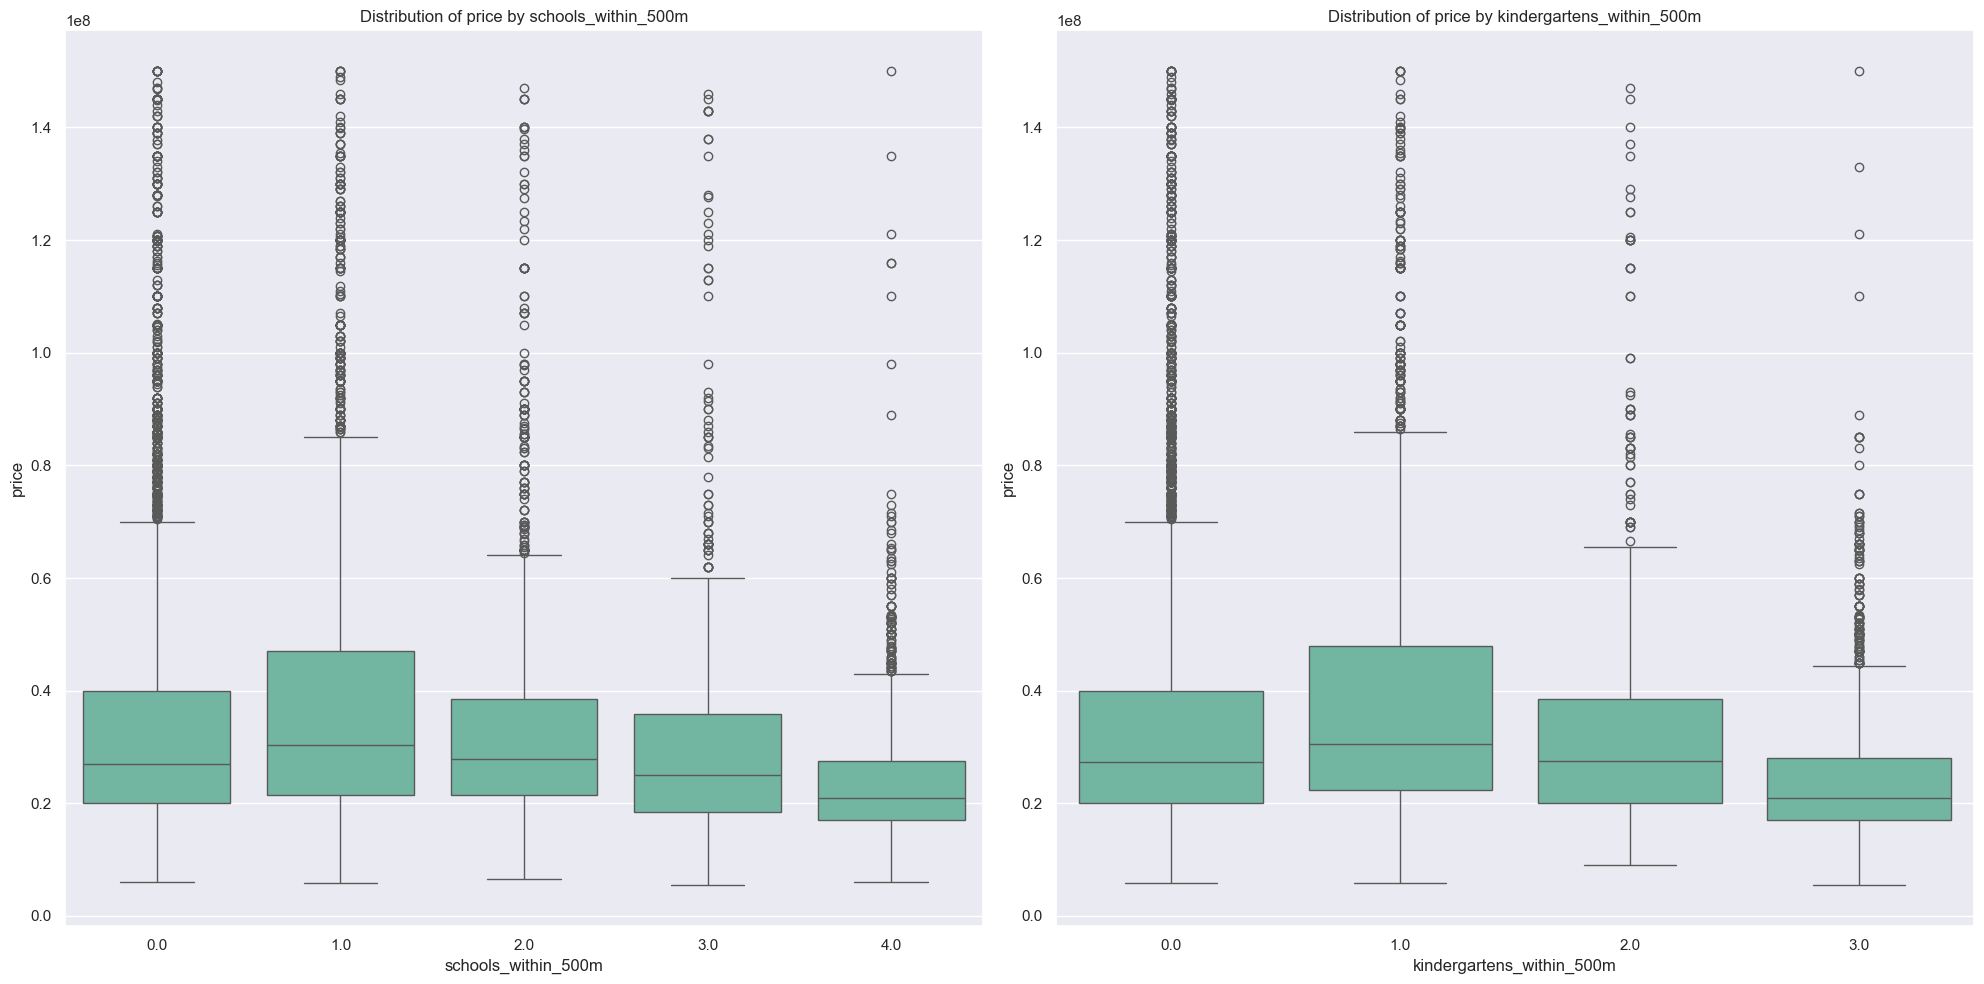

In [9]:
df['schools_within_500m'] = df['schools_within_500m'].apply(lambda x: min(x, 4))
df['kindergartens_within_500m'] = df['kindergartens_within_500m'].apply(lambda x: min(x, 3))

features =['schools_within_500m', 'kindergartens_within_500m']
target_feature = 'price'

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, feature in enumerate(features):
    sns.boxplot(x=feature, y=target_feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {target_feature} by {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_feature)

plt.tight_layout()
plt.show()

### Does the region affect the number of schools within a 500-meter radius on the price?

*Null Hypothesis*: The apartment price does not differ based on the number of schools in the neighborhood.

*Alternative Hypothesis*: The apartment price differs based on the number of schools in the neighborhood.

In [77]:
price_zero_school = df.loc[df['schools_within_500m']==0, 'price']
price_one_school = df.loc[df['schools_within_500m']==1, 'price']
price_two_school = df.loc[df['schools_within_500m']==2, 'price']
price_three_school = df.loc[df['schools_within_500m']==3, 'price']
price_four_school = df.loc[df['schools_within_500m']==4, 'price']

print('0:')
result = stats.normaltest(price_zero_school)
decision_normality(result[1])

print('1:')
result = stats.normaltest(price_one_school)
decision_normality(result[1])

print('2:')
result = stats.normaltest(price_two_school)
decision_normality(result[1])

print('3:')
result = stats.normaltest(price_three_school)
decision_normality(result[1])

print('4:')
result = stats.normaltest(price_four_school)
decision_normality(result[1])

0:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
1:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
2:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
3:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
4:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.


In [78]:
_, p = stats.kruskal(
    price_zero_school,
    price_one_school,
    price_two_school,
    price_three_school,
    price_four_school,
)
decision_hypothesis(p)

p-value = 0.000
p-value is less than the specified significance level 0.05. We reject the null hypothesis in favor of the alternative.


**The conclusion**

There is no evidence to claim that there is a difference in the price in different number of school in 500 m.

### Does the region affect the number of kindergartens within a 500-meter radius on the price?

*Null Hypothesis*: The apartment price does not differ based on the number of kindergartens in the neighborhood.

*Alternative Hypothesis*: The apartment price differs based on the number of kindergartens in the neighborhood.

In [79]:
price_zero_kindergarten = df.loc[df['kindergartens_within_500m']==0, 'price']
price_one_kindergarten = df.loc[df['kindergartens_within_500m']==1, 'price']
price_two_kindergarten = df.loc[df['kindergartens_within_500m']==2, 'price']
price_three_kindergarten = df.loc[df['kindergartens_within_500m']==3, 'price']

print('0:')
result = stats.normaltest(price_zero_kindergarten)
decision_normality(result[1])

print('1:')
result = stats.normaltest(price_one_kindergarten)
decision_normality(result[1])

print('2:')
result = stats.normaltest(price_two_kindergarten)
decision_normality(result[1])

print('3:')
result = stats.normaltest(price_three_kindergarten)
decision_normality(result[1])

0:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
1:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
2:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
3:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.


In [80]:
_, p = stats.kruskal(
    price_zero_kindergarten,
    price_one_kindergarten,
    price_two_kindergarten,
    price_three_kindergarten,
)
decision_hypothesis(p)

p-value = 0.000
p-value is less than the specified significance level 0.05. We reject the null hypothesis in favor of the alternative.


**The conclusion**

There is no evidence to claim that there is a difference in the price in  number of kindergartens in 500 m.

### Does the presence of a park in radius 1 km affect the price??

*Null Hypothesis*: The apartment price does not differ based on the presence of a park in radius 1 km.

*Alternative Hypothesis*: The apartment price differs based on the presence of a park in radius 1 km.

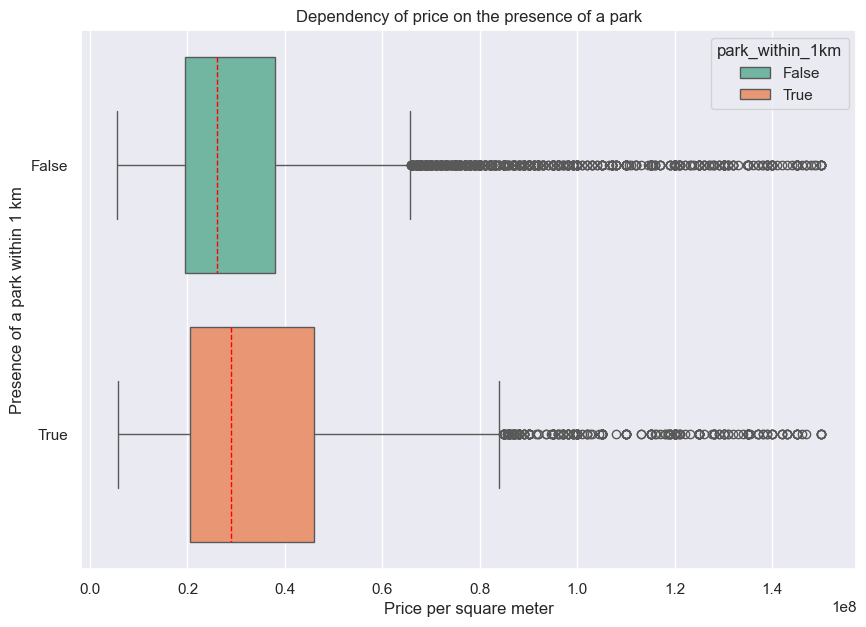

In [81]:
ax = sns.boxplot(df, x='price', y='park_within_1km', orient='h', hue='park_within_1km',  medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Price per square meter', ylabel='Presence of a park within 1 km')
plt.title('Dependency of price on the presence of a park')
plt.show()

In [86]:
park_true = df.loc[df['park_within_1km']==True, 'price']
park_false = df.loc[df['park_within_1km']==False, 'price']

print('True:')
result = stats.normaltest(park_true)
decision_normality(result[1])

print('False')
result = stats.normaltest(park_false)
decision_normality(result[1])

True:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
False
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.


In [90]:
_, p = stats.mannwhitneyu(
    park_true, park_false
)   
decision_hypothesis(p)

p-value = 0.000
p-value is less than the specified significance level 0.05. We reject the null hypothesis in favor of the alternative.


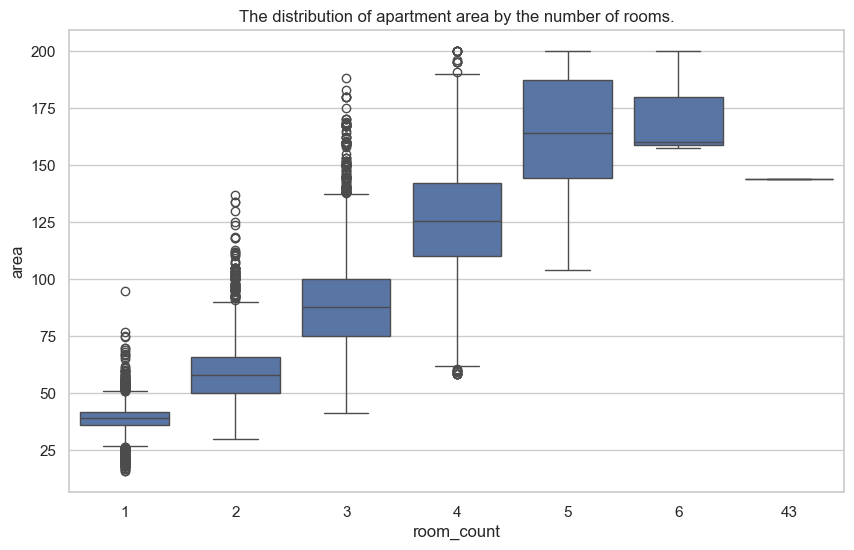

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_count', y='area', data=df)
plt.title('The distribution of apartment area by the number of rooms.')
plt.show()

In [12]:
#  We're cleaning outlier
df = df.loc[df['room_count'] <= 15]

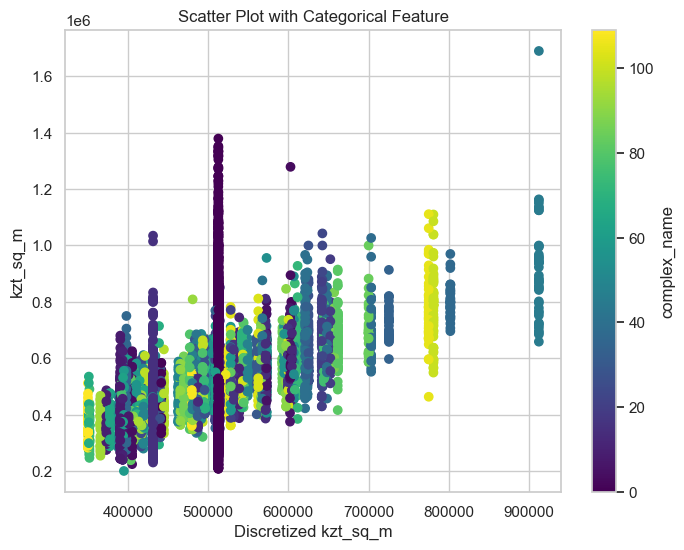

In [13]:
category_counts = df['complex_name'].value_counts()

categories_to_replace = category_counts[category_counts < 35].index

# Replace values of complex_name that occur less than 35 times with 'others'
df.loc[df['complex_name'].isin(categories_to_replace), 'complex_name'] = 'others'

# Discretizing the numeric target feature based on the categorical feature complex_name
grouped_means = df.groupby('complex_name')['kzt_sq_m'].mean()
discretized_numeric = df['complex_name'].map(grouped_means)

# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(discretized_numeric, df['kzt_sq_m'], c=pd.factorize(df['complex_name'])[0], cmap='viridis')
plt.xlabel('Discretized kzt_sq_m')
plt.ylabel('kzt_sq_m')
plt.title('Scatter Plot with Categorical Feature')
plt.colorbar(label='complex_name')
plt.show()

In [17]:
in_pledge_true = df.loc[df['in_pledge']==True, 'price']
in_pledge_false = df.loc[df['in_pledge']==False, 'price']

print('True:')
result = stats.normaltest(in_pledge_true)
decision_normality(result[1])

print('False')
result = stats.normaltest(in_pledge_false)
decision_normality(result[1])

True:
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.
False
p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.


In [18]:
_, p = stats.mannwhitneyu(
    in_pledge_true, in_pledge_false
)   
decision_hypothesis(p)

p-value = 0.102
p-value is greater than the specified significance level 0.05. We have no grounds to reject the null hypothesis.


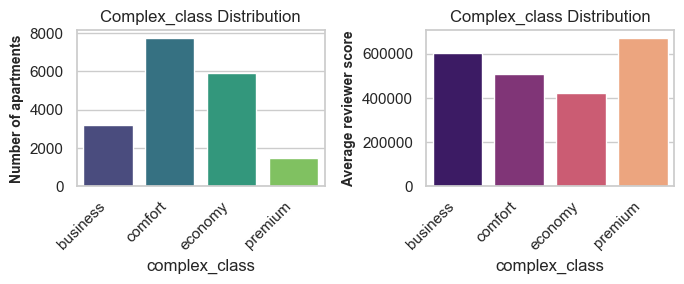

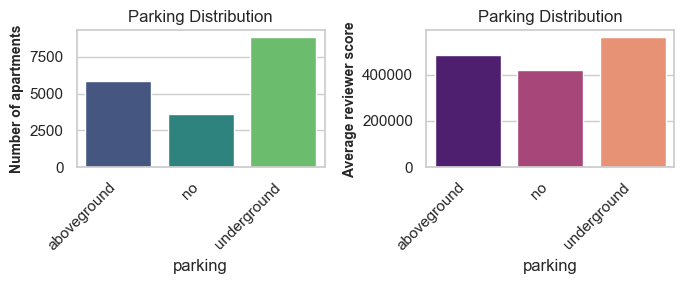

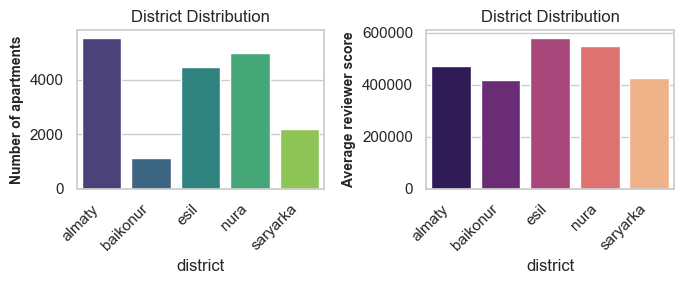

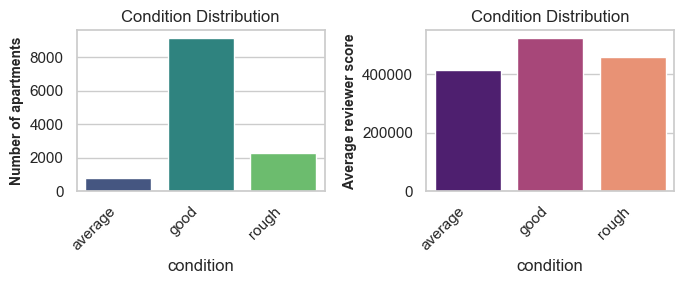

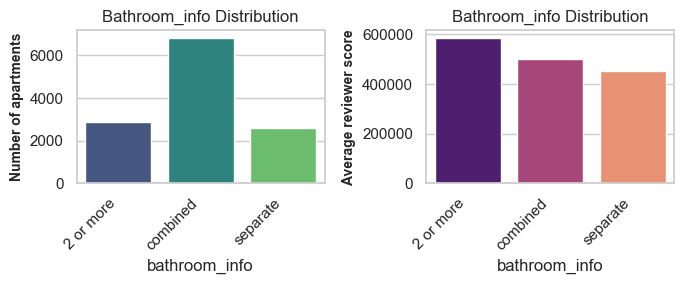

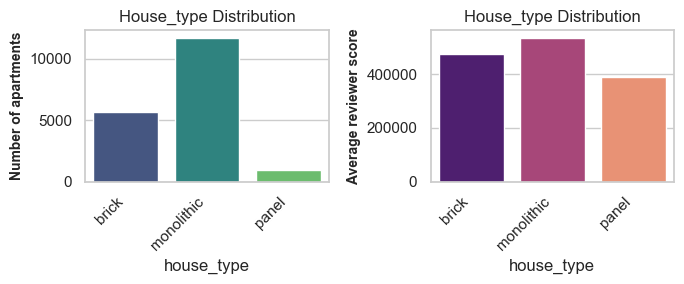

In [200]:
cat_features = ['complex_class', 'parking', 'district', 'condition', 'bathroom_info', 'house_type']

# Suppress warnings
warnings.filterwarnings("ignore")

for feature in cat_features:
    pivot = pd.pivot_table(
        data=df,
        index=feature, 
        values='kzt_sq_m', 
        aggfunc=['count', 'mean'])

    fig, ax = plt.subplots(1, 2, figsize=(7, 3))

    sns.barplot(x=pivot.index, y=pivot[('count', 'kzt_sq_m')], ax=ax[0], palette='viridis', hue=pivot.index, legend=False)
    ax[0].set_ylabel('Number of apartments', fontweight='bold', fontsize=10)
    ax[0].set_xticks(range(len(pivot.index)))  # Setting the ticks
    ax[0].set_xticklabels(pivot.index, rotation=45, ha='right')  # Setting the labels
    ax[0].set_title(f'{feature.capitalize()} Distribution')

    sns.barplot(x=pivot.index, y=pivot[('mean', 'kzt_sq_m')], ax=ax[1], palette='magma', hue=pivot.index, legend=False)
    ax[1].set_ylabel('Average reviewer score', fontweight='bold', fontsize=10)
    ax[1].set_xticks(range(len(pivot.index)))  # Setting the ticks
    ax[1].set_xticklabels(pivot.index, rotation=45, ha='right')  # Setting the labels
    ax[1].set_title(f'{feature.capitalize()} Distribution')

    plt.tight_layout()

plt.show()

In [203]:
save_data(df, "df")

### 5. Encoding
<font color='green'>In this part, we'll encode categorical variables.</font>

In [1]:
df = read_data('df')
df_copy = df.copy()
df_copy.drop(['address', 'coordinates'], axis=1, inplace=True)

# Преобразование значений True/False в 1/0 для указанных признаков
df_copy[['first_floor', 'last_floor', 'in_pledge']] = df_copy[['first_floor', 'last_floor', 'in_pledge']].astype(int)

label_encoder = LabelEncoder()
df_copy['elevator'] = label_encoder.fit_transform(df_copy['elevator'])

# Кодирование порядкого категориального признака "complex_class"
complex_class_order = ['economy', 'comfort', 'business', 'premium']  
complex_class_ordinal_encoder = OrdinalEncoder(categories=[complex_class_order])
df_copy['complex_class'] = complex_class_ordinal_encoder.fit_transform(df_copy[['complex_class']])

# Кодирование порядкого категориального признака "condition"
df_copy['condition'] = df_copy['condition'].fillna(-999)
condition_order = ['average', 'rough', 'good', -999]  
condition_ordinal_encoder = OrdinalEncoder(categories=[condition_order])
df_copy['condition'] = condition_ordinal_encoder.fit_transform(df_copy[['condition']])
df_copy['condition'] = df_copy['condition'].apply(lambda x:  -999 if x == 3.0 else x)
df_copy['condition'] = df_copy['condition'].astype(float)

# Кодирование порядкого категориального признака "bathroom_info"
df_copy['bathroom_info'] = df_copy['bathroom_info'].fillna(-999)
condition_order = ['combined', 'separate', '2 or more', -999]  
condition_ordinal_encoder = OrdinalEncoder(categories=[condition_order])
df_copy['bathroom_info'] = condition_ordinal_encoder.fit_transform(df_copy[['bathroom_info']])
df_copy['bathroom_info'] = df_copy['bathroom_info'].apply(lambda x:  -999 if x == 3.0 else x)
df_copy['bathroom_info'] = df_copy['bathroom_info'].astype(float)

nominal_categorical_features = ['parking', 'district', 'house_type', 'ceiling_height', 'owner']
df_copy = pd.get_dummies(df_copy, columns=nominal_categorical_features)

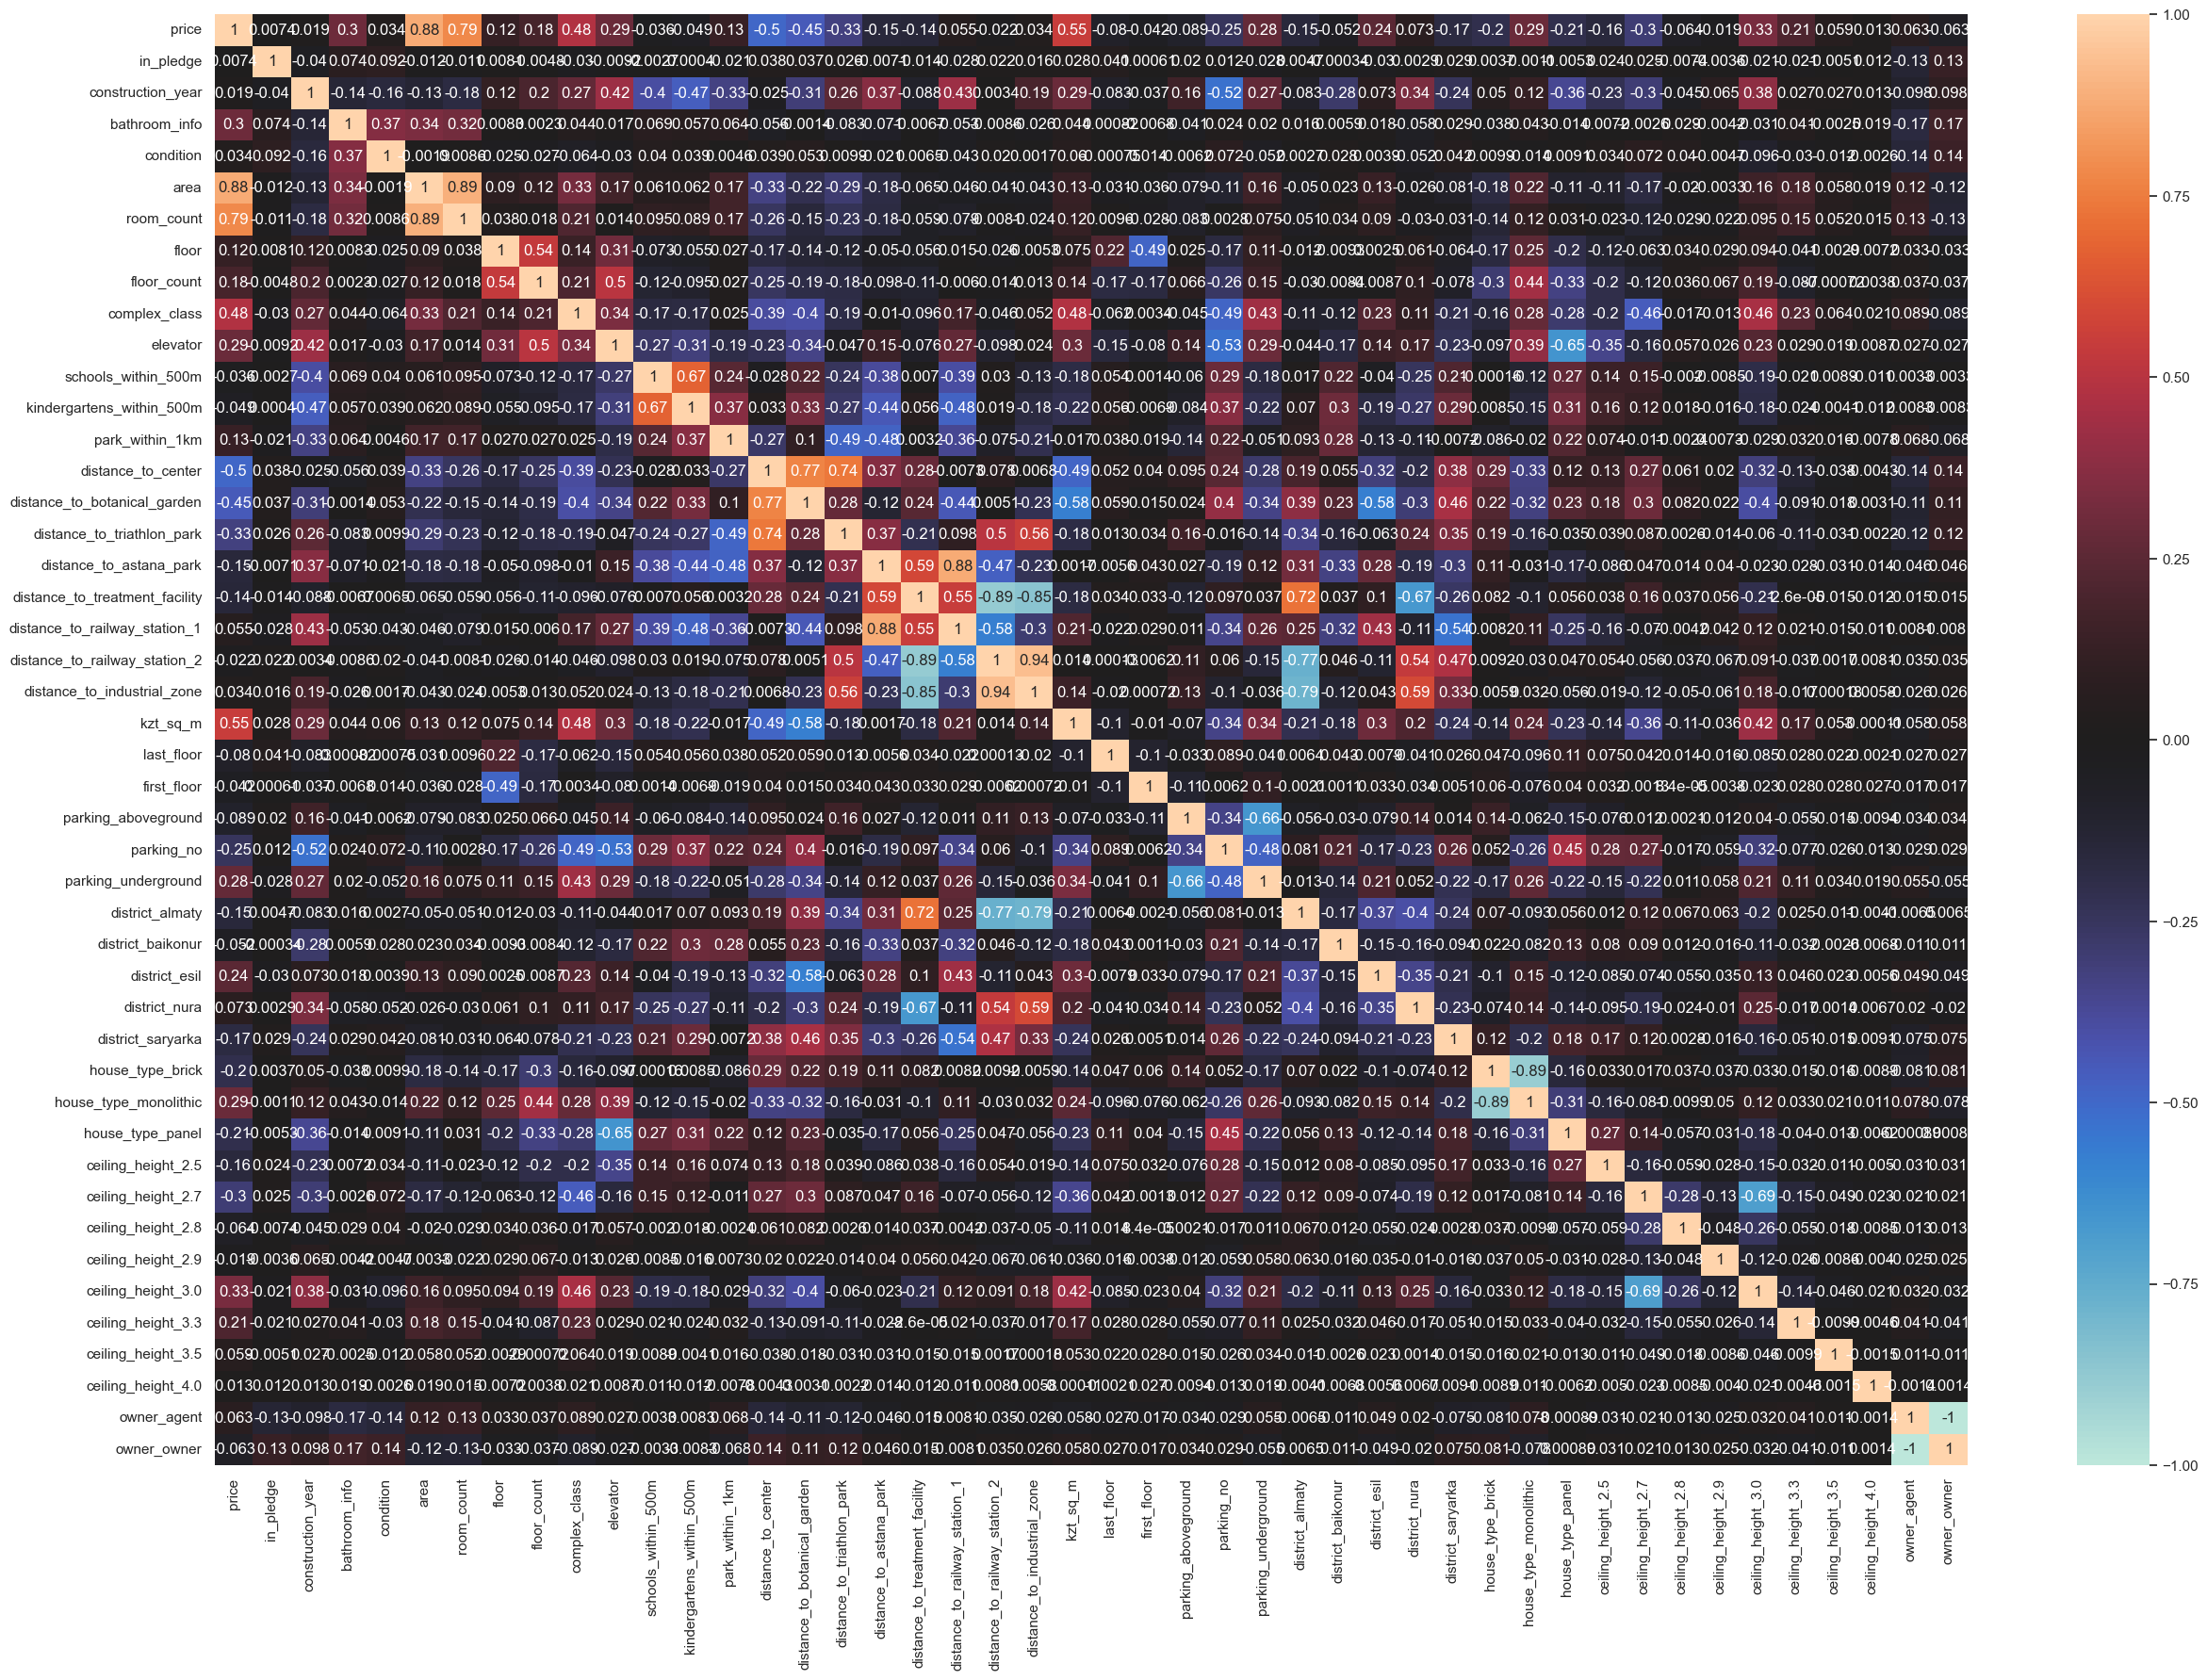

In [ ]:
corr = df_copy.corr(method='spearman')

plt.rcParams['figure.figsize'] = (30, 20)
heatmap_corr = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0)

plt.show()

In [ ]:
df_copy.drop('area', axis=1, inplace=True)
df_copy.drop('owner_agent', axis=1, inplace=True)
df_copy.drop('house_type_monolithic', axis=1, inplace=True)
df_copy.drop('distance_to_treatment_facility', axis=1, inplace=True)

### 6. Model Training
<font color='green'>Finally, we'll train a machine learning model on the processed data.</font>

In [ ]:
X = df_copy.drop(columns=['price'])
y = df_copy['price']

# X = X.astype(float)
# y = X.astype(float)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

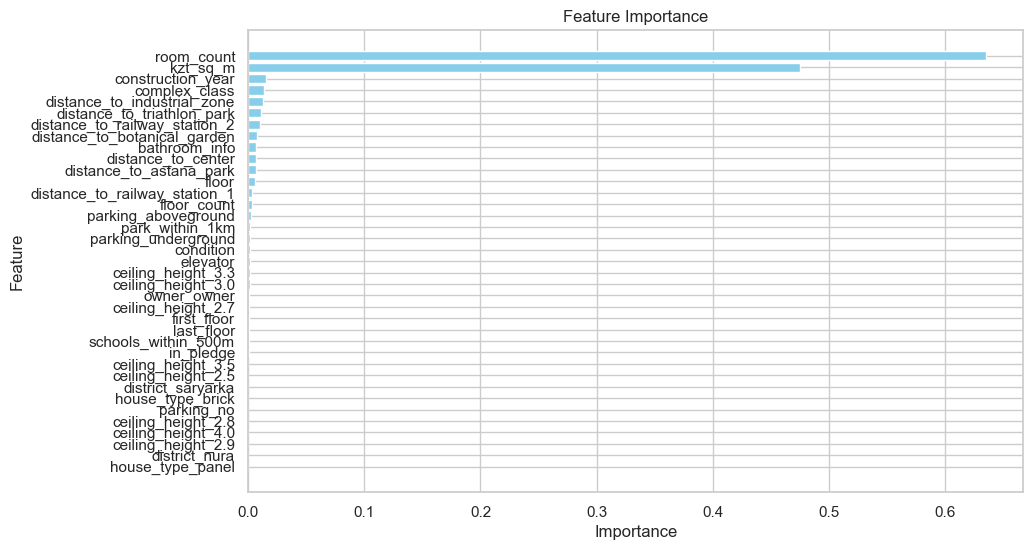


Non-important features (Importance <= 0):

                      Feature  Importance
25            district_almaty     0.00000
26          district_baikonur    -0.00001
27              district_esil    -0.00035
10  kindergartens_within_500m    -0.00111


In [ ]:
# Масштабирование данных с использованием MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели XGBoost
model = xgb.XGBRegressor()
model.fit(X_train_scaled, y_train)


# Вычисление важности признаков с использованием permutation-based feature importance
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Вывод важности признаков
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.round(result.importances_mean, 5)})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

threshold=0
important_features = importance_df[importance_df['Importance'] > threshold]
# Сортировка признаков по важности
important_features = important_features.sort_values(by='Importance', ascending=True)

# Создание bar-графика
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Вывод признаков, которые не прошли порог важности
non_important_features = importance_df[importance_df['Importance'] <= threshold]
if len(non_important_features) > 0:
    print("\nNon-important features (Importance <= {}):\n".format(threshold))
    print(non_important_features)